In [2]:
import os
import json
import gzip
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as sci
import scipy.stats as scs
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LogNorm
from astropy.time import Time as astrotime

from tdepps.utils import (make_rate_records, rebin_rate_rec,
                          make_spl_edges, fit_spl_to_hist, arr2str,
                          power_law_flux, dict_map, fill_dict_defaults,
                          make_src_records, make_src_records)
from tdepps.grb import GRBLLH, GRBModel, MultiGRBLLH
from tdepps.grb import (SignalFluenceInjector, UniformTimeSampler,
                        HealpySignalFluenceInjector,
                        TimeDecDependentBGDataInjector)
from tdepps.grb import MultiBGDataInjector, MultiSignalFluenceInjector
import tdepps.grb.analysis as GRBAna
from tdepps.grb import SinusFixedConstRateFunction
import tdepps.utils.phys as phys
import tdepps.utils.stats as stats

from mypyscripts.stats import sigma2prob, prob2sigma

from _loader import loader as LOADER
from _paths import PATHS_ORIG as PATHS  # Use the original 22 HESE sources
import _plots as plots

# Make some globals
SECINDAY = 24. * 60. * 60.
RNDGEN = np.random.RandomState(42439462)
loader = LOADER(PATHS, verb=False)

print("Started: ", astrotime.now())
print("Paths are:\n", PATHS)

Started:  2018-05-04 11:07:35.587175
Paths are:
         repo: /Users/tmenne/git/work/time
        data: /Users/tmenne/Downloads/hese_transient_stacking_data/rawout_original_hese
       local: /Users/tmenne/Downloads/hese_transient_stacking_data/out_original_hese
 skylab_data: /Users/tmenne/Downloads/hese_transient_stacking_data/skylab_data
       plots: /Users/tmenne/git/work/time/plots_new_structure/original_hese


#### Pre-loading stuff

Make a local source list version with adapted paths, only when an updated version from cobalt is fetched


In [ ]:
from _loader import _change_local_src_map_paths
_change_local_src_map_paths(PATHS.local)

Reload stuff mini example:

```Python
# GRBLLHAnalysis was loaded with: from tdepps.grb import GRBLLHAnalysis
import tdepps.grb.analysis as ANA
reload(ANA)
GRBLLHAnalysis = ANA.GRBLLHAnalysis
```

## Single sample

**TODO**
Put all plots for single samples in the multi sample part.

### Load sample

In [ ]:
# Check loaders for available names
tw_id = 10
sample_name = "IC86_2012-2014"  # IC79, IC86_2011, IC86_2012-2014, IC86_2015

dt0, dt1 = loader.time_window_loader(tw_id)
srcs = loader.source_list_loader(sample_name)
runlist_dict = loader.runlist_loader(sample_name)

# Data
exp_off_dict = loader.off_data_loader(sample_name)
exp_on_dict = loader.on_data_loader(sample_name)
mc_dict = loader.mc_loader(sample_name)

# Process to other formats
exp_off = exp_off_dict[sample_name]
exp_on = exp_on_dict[sample_name]
mc = mc_dict[sample_name]
srcs_rec = make_src_records(srcs[sample_name], dt0=dt0, dt1=dt1)
runlist = runlist_dict[sample_name]
rate_recs = make_rate_records(exp_off["Run"], run_list=runlist)

### Setup models

In [ ]:
# Binning
# Finer resolution around the horizon region, where we usually switch the event
# selections from northern to southern samples
hor = np.sin(np.deg2rad(30))
sindec_bins = np.unique(np.concatenate([
                        np.linspace(-1., -hor, 3 + 1),    # south
                        np.linspace(-hor, +hor, 14 + 1),  # horizon
                        np.linspace(+hor, 1., 3 + 1),     # north
                        ]))
nbins = 12 if not sample_name == "IC86_2012-2014" else 3 * 12
rate_rebins = np.linspace(np.amin(exp_off["time"]),
                          np.amax(exp_off["time"]), nbins)

logE_bins = np.linspace(np.floor(np.amin(mc["logE"])),
                        np.ceil(np.amax(mc["logE"])), 30)

def flux_model(trueE):
    return power_law_flux(trueE, gamma=2.19)

In [ ]:
# Build and fit bg injector
# Choose spl_s so that the spline sticks a little more to the data
bg_inj_opts = {"sindec_bins": sindec_bins, "rate_rebins": rate_rebins,
               "spl_s": len(sindec_bins) // 2, "n_scan_bins": 25}
bg_inj = TimeDecDependentBGDataInjector(inj_opts=bg_inj_opts,
                                        random_state=RNDGEN)
bg_inj.fit(X=exp_off, srcs=srcs_rec, run_list=runlist)
bg_inj_opts = bg_inj.inj_opts

In [ ]:
# Build and fit sig injector
sig_inj_opts = {"mode": "band", "sindec_inj_width": 0.035,
                "dec_range": np.array([-np.pi / 2., np.pi / 2.])}
time_sam = UniformTimeSampler(random_state=None)
sig_inj = SignalFluenceInjector(flux_model=flux_model, time_sampler=time_sam,
                                inj_opts=sig_inj_opts)
sig_inj.fit(srcs_rec, MC=mc)
sig_inj_opts = sig_inj.inj_opts

In [ ]:
# Build and fit llh model
mod_spatial_opts = dict(bg_inj_opts.items(), select_ev_sigma=5., kent=True)

# Test signal weightes, if gammas are same, then ratio is 1 everywhere
# mc_bg_w = MC_["ow"] * power_law_flux(MC_["trueE"], gamma=2.19)
mc_bg_w = None

mod_energy_opts = {"bins": [sindec_bins, logE_bins],
                   "flux_model": flux_model, "mc_bg_w": mc_bg_w,
                   "force_logE_asc": True, "edge_fillval": "minmax_col",
                   "interp_col_log": False}
grb_mod = GRBModel(X=exp_off, MC=mc, srcs=srcs_rec, run_list=runlist,
                   spatial_opts=mod_spatial_opts,
                   energy_opts=mod_energy_opts)
llh = GRBLLH(llh_model=grb_mod, llh_opts=None)
llh_opts = llh.llh_opts

In [ ]:
ana = GRBAna.GRBLLHAnalysis(llh, bg_inj, sig_inj)

### Tests

In [ ]:
def save_plot(folder, fname, **savefig_args):
    """ Checks existence of save folder and saves current figure."""
    dpi = savefig_args.pop("dpi", 200)
    bbox_inches = savefig_args.pop("bbox_inches", "tight")
    outp = os.path.join(PATHS.plots, folder)
    if not os.path.isdir(outp):
        os.makedirs(outp)
    plt.tight_layout()
    fname = os.path.join(outp, fname)
    plt.savefig(fname, dpi=dpi, bbox_inches=bbox_inches, **savefig_args)
    print("Saved plot to:\n  {}".format(fname))

#### Split on/off data

In [ ]:
# Load all data for comparison
name2skylab = {
    "IC79" : "IC79b_exp.npy",
    "IC86_2011" : "IC86_exp.npy",
    "IC86_2012-2014" : ["IC86-2012_exp_v2.npy",
                        "IC86-2013_exp_v2.npy",
                        "IC86-2014_exp_v2.npy"],
    "IC86_2015" : "SplineMPEmax.MuEx.IC86-2015.npy",
}
if isinstance(name2skylab[sample_name], list):
    _files = [os.path.join(PATHS.skylab_data, n) for n
              in name2skylab[sample_name]]
    _exp = np.concatenate([np.load(n) for n in _files])
else:
    _exp = np.load(os.path.join(PATHS.skylab_data, name2skylab[sample_name]))
    
_ev_t_all = _exp[::10]["time"]
_ev_t_off = exp_off[::10]["time"]
_ev_t_on = exp_on[::10]["time"]
# Load largest window to show borders
dt0_max, dt1_max = loader.time_window_loader(-1)

for i, t in enumerate(srcs_rec["time"]):
    plt.vlines(_ev_t_all, 0, 1, colors="C7", label="all")
    plt.vlines(_ev_t_off, 1, 2, colors="C1", label="off time")
    plt.vlines(_ev_t_on, 1.2, 1.8, colors="C0", label="on time")

    plt.axhline(1, 0, 1, ls="-", c="k")
    plt.axvline(t, 0, 1, ls="-", c="k", label="src time")
    plt.axvline(t + dt0_max / SECINDAY, 0, 1, ls="--", c="k")
    plt.axvline(t + dt1_max / SECINDAY, 0, 1, ls="--", c="k")
    
    plt.xlim(t + 2 * dt0 / SECINDAY, t + 2 * dt1 / SECINDAY)
    
    plt.xlabel("MJD")
    plt.ylabel("MJD")
    plt.legend()
    plt.show()

In [ ]:
# Show all off data again, hard to see but global
plt.vlines(exp_off["time"][::100], 0, 1)

plt.vlines(srcs_rec["time"] + dt0_max / SECINDAY, 0, 1, linestyles="--",
           colors="C0")
plt.vlines(srcs_rec["time"] + dt0_max / SECINDAY, 0, 1, linestyles="--",
           colors="C0")

plt.xlabel("MJD")
plt.show()

#### Filtered HESE events in MC

Manually load all data and recreate LLH model with new MC

In [ ]:
def remove_hese_from_mc(mc, heseids):
    """
    Mask all values in ``mc`` that have the same run and event ID combination
    as in ``heseids``.

    Parameters
    ----------
    mc : record-array
        Needs names ``'Run', 'Event'``.
    heseids : dict or record-array
        Needs names / keys ``'run_id', 'event_id``.

    Returns
    -------
    is_hese_mask : array-like, shape (len(mc),)
        Mask: ``True`` if for each event in ``mc`` that is HESE like.
    """
    # Make combined IDs to easily match against HESE IDs with `np.isin`
    factor_mc = 10**np.ceil(np.log10(np.amax(mc["Event"])))
    _evids = np.atleast_1d(heseids["event_id"])
    factor_hese = 10**np.ceil(np.log10(np.amax(_evids)))
    factor = max(factor_mc, factor_hese)

    combined_mcids = (factor * mc["Run"] + mc["Event"]).astype(int)
    assert np.all(combined_mcids > factor)  # Is int overflow a thing here?

    _runids = np.atleast_1d(heseids["run_id"])
    combined_heseids = (factor * _runids + _evids).astype(int)
    assert np.all(combined_heseids > factor)

    # Check which MC event is tagged as HESE like
    is_hese_mask = np.isin(combined_mcids, combined_heseids)
    print("  Found {} / {} HESE like events in MC".format(np.sum(is_hese_mask),
                                                          len(mc)))
    return is_hese_mask


name2skylab = {
    "IC79" : "IC79b_corrected_MC.npy",
    "IC86_2011" : "IC86_corrected_MC.npy",
    "IC86_2012-2014" : "IC86-2012_corrected_MC_v2.npy",
    "IC86_2015" : "SplineMPEmax.MuEx.MC.npy",
}
name2idx = {
    "IC79" : "IC79.json.gz",
    "IC86_2011" : "IC86_2011.json.gz",
    "IC86_2012-2014" : "IC86-2012-2015.json.gz",
    "IC86_2015" : "IC86-2012-2015.json.gz",    
}

# Load full skylab data
_mc = np.load(os.path.join(PATHS.skylab_data, name2skylab[sample_name]))

# Filter HESE events
_path = os.path.join(PATHS.local, "check_hese_mc_ids", name2idx[sample_name])
heseids = json.load(gzip.open(_path))
is_hese_mask = remove_hese_from_mc(_mc, heseids)

In [ ]:
# Plot filtered out HESE events
_mc_hese = _mc[is_hese_mask]
_mc_no_hese = _mc[~is_hese_mask]

w_hese = _mc_hese["ow"] * power_law_flux(_mc_hese["ow"], gamma=2.19)
w_no_hese = _mc_no_hese["ow"] * power_law_flux(_mc_no_hese["ow"], gamma=2.19)

fig, (axl, axr) = plt.subplots(1, 2, figsize=(10, 4))
h, bx, by, img = axl.hist2d(np.sin(_mc_no_hese["dec"]),
                            np.log10(_mc_no_hese["trueE"]),
                            bins=50, norm=LogNorm(), cmap="inferno",
                            weights=w_no_hese)
fig.colorbar(img, ax=axl)
_, _, _, img = axr.hist2d(np.sin(_mc_hese["dec"]), np.log10(_mc_hese["trueE"]),
                          bins=[bx, by], norm=LogNorm(), cmap="inferno",
                          weights=w_hese, vmax=np.amax(h))
fig.colorbar(img, ax=axr)
axl.set_title("No HESE")
axr.set_title("Only HESE like")
plt.show()

_, b, _ = plt.hist(np.log10(_mc["trueE"]), bins=50, alpha=0.5,
                   density=False, label="All",
                   weights=_mc["ow"] * power_law_flux(_mc["ow"], gamma=2.19))
_ = plt.hist(np.log10(_mc_hese["trueE"]), bins=b, alpha=0.5,
             density=False, label="Only HESE like",
             weights=_mc_hese["ow"] * power_law_flux(_mc_hese["ow"],
                                                     gamma=2.19))
plt.yscale("log", nonposy="clip")
plt.legend()
plt.show()

#### Rate allsky model

In [ ]:
# Redo the allsky rate fit for testing
recs = make_rate_records(T=exp_["time"], run_dict=run_dict_)
rates, new_bins, stddev, _ = rebin_rate_rec(rate_rec=recs, bins=rate_rebins,
                                     ignore_zero_runs=True)
mids = 0.5 * (new_bins[:-1] + new_bins[1:])

rate_func = SinusFixedConstRateFunction(p_fix=365.)
allsky_res = rate_func.fit(rate=rates, srcs=srcs_, t=mids, w=1. / stddev)

t0_fix = allsky_res.x[1]
print("Best fit t0 before first event: ",
      t0_fix - exp_["time"].min(), "days")

rate_func = SinusFixedConstRateFunction(p_fix=365., t0_fix=t0_fix)

#### BG splines and sampling

Show build spline models for timedependent injector

In [ ]:
x = np.linspace(-1, 1, 100)
bins = bg_inj_opts["sindec_bins"]
mids = 0.5 * (bins[:-1] + bins[1:])
allsky_pars = bg_inj._spl_info["allsky_best_params"]
print("Allsky best params: " + arr2str(allsky_pars))

TEST = False

for n in ["amp", "base"]:
    spl = bg_inj._spl_info["param_splines"][n]
    vals = np.copy(bg_inj._spl_info["best_pars_norm"][n])
    err = np.copy(bg_inj._spl_info["best_stddevs_norm"][n])
         
    # Quickly switch smoothing for testing
    if TEST:
        w = 1. / err
        vals_, pts_, w = make_spl_edges(vals=vals, bins=sindec_bins, w=w)
        stop = False
        s_ = bg_inj_opts["spl_s"]
        spl_ = sci.UnivariateSpline(pts_, vals_, w=w, s=s_)
        _last_max_der2 = np.amax(np.abs(spl_.derivative(n=2)(x)))
        _last_down = False
        print("Start with: ", s_, _last_down, _last_max_der2)
        i = 0
        while not stop and i < 50:
            spl_ = sci.UnivariateSpline(pts_, vals_, w=w, s=s_)
            norm_ = (allsky_pars[0] if n == "amp" else allsky_pars[-1])

            spl2_ = spl_.derivative(n=2)
            _der2 = np.abs(spl2_(x))
            stop = np.all(_der2 < 1.)
            if not stop:
                print("  Current: ", _last_down, _last_max_der2)
                _max_der2_cur = np.amax(_der2)
                if (_last_max_der2 <= _max_der2_cur) and not _last_down:
                    s_ *=  0.8
                    _last_down = True
                    print("Going down. 2nd derivative was ",
                          _max_der2_cur, " New : ", s_, _last_down)
                elif (_last_max_der2 <= _max_der2_cur) and _last_down:
                    s_ *=  1.2
                    _last_down = False
                    print("Going up. 2nd derivative was ",
                          _max_der2_cur, " New : ", s_, _last_down)
                elif _last_down:
                    s_ *=  0.8
                    print("Going down. 2nd derivative was ",
                          _max_der2_cur)
                else:
                    s_ *=  1.2
                    print("Going up. 2nd derivative was ",
                          _max_der2_cur)
                _last_max_der2 = _max_der2_cur
            i += 1
#                 plt.plot(x, spl_(x), color="C0", ls="--")
#                 plt.show()
        print("Finish: ", s_)
        if i == 50:
            print("Reached maxiter")

        # Renorm to allsky for comparison
        scale_ = norm_ / spl_.integral(-1, 1)
   
    fig, ax = plt.subplots(1, 1)
    ax.plot(x, spl(x), color="k")
    ax.plot(mids, vals, color="C7", ls="--")
    ax.errorbar(mids, vals, yerr=err, fmt="o", color="C1")
    
    if n == "amp":
        ax.axhline(0, 0, 1, color="C7", ls="--")
    else:
        ax.set_ylim(0, None)

    ax.set_xlabel("sindec")
    ax.set_ylabel(n)
    ax.set_title("Integral: {:.3f} mHz".format(spl.integral(-1, 1) * 1e3))
    # Show sindec bin borders
    ylim = ax.get_ylim()
    ax.vlines(sindec_bins, ylim[0], ylim[1],
               linestyles=":", colors="C7")
    ylim = ax.set_ylim(ylim)

    plt.show()

Compare hist to allsky model

In [ ]:
x = np.linspace(-1, 1, 200)
bins = 100
plt.vlines(sindec_bins, 0, 1, linestyles="--", colors="C7", zorder=-1)
plt.hist(np.sin(exp_off["dec"]), bins=bins, density=True)
plt.plot(x, bg_inj._spl_info["data_sin_dec_pdf_spline"](x))

plt.show()

Make multiple trials and concat to compare to spline with large stats.
Use internal debug var to get samples per source to compare to splines.

In [ ]:
nsrcs = len(bg_inj.srcs)
sam = [list() for _ in range(nsrcs)]
nsamples = 1000
for _ in range(nsamples):
    sami = bg_inj.sample(debug=True)
    src_idx = bg_inj._sample_idx["src_idx"]
    for j in range(nsrcs):
        sam[j].append(sami[src_idx == j])
        
sam = [np.concatenate(sami) for sami in sam]

In [ ]:
# These should match closely
print(map(lambda spl: spl.integral(-1, 1),
          bg_inj._spl_info["sin_dec_splines"]))
print(bg_inj._nb)

In [ ]:
x = np.linspace(-1, 1, 200)
bins = bg_inj_opts["sindec_bins"]
bins = np.linspace(-1, 1, 40)
for j, sami in enumerate(sam):
    plt.vlines(sindec_bins, 0, 1, linestyles="--", colors="C7", zorder=-1)
    # Plot allyear sample for comparison
    plt.hist(np.sin(exp_off["dec"]), bins=bins, density=True, color="0.75")
    plt.plot(x, bg_inj._spl_info["data_sin_dec_pdf_spline"](x),
             color="C0", ls=":", lw=3)
    # Drawn sample per source. Red hist should approx. follow black spline
    # It doesnt here because we need to make the allsky bg spline follow the
    # data as close as possbile, but we chose sindec spliens so that didn't work
#     plt.hist(np.sin(sami["dec"]), bins=bins, density=True,
#              histtype="step", lw=2.5, color="C3")
    plt.plot(x, bg_inj._spl_info["sin_dec_pdf_splines"][j](x), color="k")
    plt.xlabel("sin dec")
    plt.ylabel("PDF")
    plt.title("{}. Source {:02d}".format(sample_name, j))
    
#     save_plot(os.path.join("bg_injector", "sindec_splines"),
#               "{}_src_{:02d}.png".format(sample_name, j))
    plt.show()

Show sampling weights

In [ ]:
pts = np.sin(exp_off["dec"])
idx = np.argsort(pts)
pts = pts[idx]

for j, w in enumerate(bg_inj._spl_info["sample_weights"]):
    plt.plot(pts, w[idx])

plt.axhline(1, 0, 1, c="k")
plt.xlabel("sin dec")
plt.ylabel("Sample weights")
plt.title("{}".format(sample_name))

save_plot(os.path.join("bg_injector", "sindec_splines"),
          "{}_sample_weights.png".format(sample_name))
plt.show()

#### MC Injector

In [ ]:
# Testing signal injector
sam = sig_inj.sample(n_samples=10000)
idx = sig_inj._sample_idx

In [ ]:
# Sampled MC hist
for name in ["ra", "dec", "logE", "time", "sigma"]:
    # Show sampled data-like attributes
    if name != "time":
        # Compare to full MC pool distribution
        w = sig_inj._MC["ow"] * sig_inj.flux_model(sig_inj._MC["trueE"])
        _ = plt.hist(sig_inj._MC[name], weights=w, density=True, bins=100,
                     alpha=.5)
        _ = plt.hist(sam[name], density=True, bins=100, histtype="step", lw=3)
    if name in ["ra", "dec"]:
        plt.vlines(sig_inj.srcs[name], 0, 1)
        plt.yscale("log", nonposy="clip")
    if name == "time":
        ts = sig_inj.srcs["time"]
        dt0s, dt1s = sig_inj.srcs["dt0"], sig_inj.srcs["dt1"]
        for j in range(len(ts)):
            plt.title("{}. {:.2f}, {:.2f}, {:.2f}".format(
                name, ts[j], dt0s[j], dt1s[j]))
            mask = (idx["src_idx"] == j)
            trel = (ts[j] - sam[name][mask]) * SECINDAY
            _ = plt.hist(trel, density=False, bins=100,
                         histtype="step", lw=3)
            plt.axvline(0, 0, 1)
            plt.axvline(dt0s[j], 0, 1, ls="--")
            plt.axvline(dt1s[j], 0, 1, ls="--")
            plt.show()
    else:
        plt.title(name)
        plt.show()

Show sindec distribution used for sampling

In [ ]:
plt.hist(np.sin(mc["trueDec"]), bins=np.linspace(-1, 1, 100),
                weights=mc["ow"] * flux_model(mc["trueE"]))

for srci in srcs_rec:
    plt.axvline(np.sin(srci["dec"]), 0, 1, ls="--", c="k")
    
plt.show()

Show injected event positions and full weighted MC distribtuion together with spline used to get src weights.
Relativ number of injected events should scatter around the spline which models the expected injection.
If injection bands are too broad they may start to differ.

In [ ]:
# Sample a bit more for better stats
nsamples = 10000
_Xsig = sig_inj.sample(n_samples=nsamples)
_src_idx = sig_inj._sample_idx["src_idx"]

bins = grb_mod._spatial_opts["sindec_bins"]
mids = 0.5 * (bins[:-1] + bins[1:])
lo, hi = bins[0], bins[-1]

# Make signal distribution from which is sampled
w_sig = mc["ow"] * flux_model(mc["trueE"])
sindec = np.sin(mc["trueDec"])
hist, _ = np.histogram(sindec, bins=sindec_bins, weights=w_sig)
var, _ = np.histogram(sindec, bins=sindec_bins, weights=w_sig**2)
dA = np.diff(bins)
hist = hist / dA
stddev = np.sqrt(var) / dA

# Normalize hist as injection weights: sum w = 1. Get weights from src weights
src_w = grb_mod.get_args()["src_w_dec"]
norm = np.sum(src_w)
spl = grb_mod._spl_info["mc_sin_dec_pdf_spline"]
hist = hist / norm
stddev = stddev / norm

# Plot the spline and the histogram
x = np.linspace(lo, hi, 250)
plt.plot(bins, np.r_[hist[0], hist], drawstyle="steps-pre", color="C7")
plt.errorbar(mids, hist, yerr=stddev, fmt=",", color="C7")
plt.plot(x, spl(x) / norm)

for j, srci in enumerate(sig_inj.srcs):
    # Plot source positions in dec
    plt.axvline(np.sin(srci["dec"]), 0, 1, ls="--", c="C7")
    # Plot relativ number of sampled events per src
    m = (_src_idx == j)
    nsam = np.sum(m) / len(m)
    nsam_err = np.sqrt(np.sum(m)) / len(m)
    plt.errorbar(np.sin(srci["dec"]), nsam, yerr=nsam_err,
                 fmt="o", c="C{}".format(j), zorder=5, alpha=1.)
    # Plot 1D scatter of sampled events per source
    plt.vlines(np.sin(_Xsig[m]["dec"]), -0.15 * np.amax(hist), 0.,
               linestyles="-", colors="C{}".format(j), alpha=0.1)
    # Plot expected relativ event numbers (spline values)
    plt.plot(np.sin(srci["dec"]), src_w[j] / norm, c="C{}".format(j),
             marker="d", ls="", mec="k", zorder=6)

    plt.axhline(0, 0, 1, c="k", ls="-")
    
plt.ylim(-0.15 * np.amax(hist), None)
plt.title(sample_name)

# plt.savefig("/Users/tmenne/Downloads/mc_inject_expect_" +
#             "{}_nsam={}.png".format(sample_name, nsamples), dpi=200)
plt.show()

#### LLH model

Sample some data and get soverb

In [ ]:
Xbg = bg_inj.sample()
Xsig = sig_inj.sample(n_samples=20)
X = np.concatenate((Xbg, Xsig))

bg_idx = bg_inj._sample_idx["src_idx"]
sig_idx = sig_inj._sample_idx["src_idx"]
src_idx = np.concatenate((bg_idx, sig_idx))

dec_mask = grb_mod._select_X(X)

Show the band selection effect (only dec band selection for now)

In [ ]:
nsig = grb_mod._spatial_opts["select_ev_sigma"]

# Scatter all, highlight selected events per src
plt.scatter(X["ra"], X["dec"], s=100*np.rad2deg(X["sigma"]), color="C7",
            alpha=.5)
for j, m in enumerate(dec_mask):
    plt.scatter(X[m]["ra"], X[m]["dec"], s=10*np.rad2deg(X[m]["sigma"]),
                color="C{}".format(j))
    plt.scatter(srcs_rec[j]["ra"], srcs_rec[j]["dec"], color="C{}".format(j),
                marker="*", edgecolor="k", linewidth=1, s=100)
plt.xlim(0, 2 * np.pi)
plt.ylim(-np.pi / 2, np.pi / 2)
plt.xlabel("ra")
plt.ylabel("dec")
plt.show()

# Plot all that made the selection
if tw_id < 16:
    for j, srci in enumerate(grb_mod.srcs):
        # Combining the masks show not all selected, because an injected event
        # can of course show up for a different src, especially in BG
        # m = (src_idx == j) & dec_mask[j]
        # This simply show, if the global dec band selection is working
        m = dec_mask[j]
        los = X["dec"][m] - nsig * X[m]["sigma"]
        his = X["dec"][m] + nsig * X[m]["sigma"]
        for i, (lo, hi) in enumerate(zip(los, his)):
            plt.fill_between([lo, hi], [i, i], [i+1, i+1], alpha=.25,
                             color="C{}".format(j))
            plt.vlines(X["dec"][m][i], i, i+1, color="C{}".format(j),
                       linestyles="-")
        plt.axvline(srci["dec"], 0, 1, color="C{}".format(j), ls="--",
                    label="src {}".format(j))
    plt.xlabel("dec")
    plt.legend()
    plt.title("Events that made the selection")

    plt.show()
else:
    print("Skipping midlle plot with too many events...")
    
# And all that didn't (only if there aren't so many events, takes too long)
if tw_id < 16:
    mask = np.any(dec_mask, axis=0)
    los = X["dec"][~mask] - nsig * X[~mask]["sigma"]
    his = X["dec"][~mask] + nsig * X[~mask]["sigma"]
    for j, (lo, hi) in enumerate(zip(los, his)):
        plt.fill_between([lo, hi], [j, j], [j+1, j+1], alpha=.25, color="C3")
        plt.vlines(X["dec"][~mask][j], j, j+1, color="C3")
    for j, srci in enumerate(grb_mod.srcs):
        plt.axvline(srci["dec"], 0, 1, color="C{}".format(j),
                    ls="--", label="src {}".format(j))
    plt.xlabel("dec")
    plt.legend()
    plt.title("Events that didn't make the selection")

    plt.show()
else:
    print("Skipping last plot with too many events...")

In [ ]:
# Here we combine both masks to show selected events, that also belong to a
# specific source by the time selection. That's why there might be no events
# here, even if they were shown in the plot above.
for j in range(len(grb_mod.srcs)):
    _bg = Xbg["time"][bg_idx == j]
    _sig = Xsig["time"][sig_idx == j] 
    _src = grb_mod.srcs[j]["time"]

    trel_bg = (_bg - _src) * SECINDAY
    trel_sig = (_sig - _src) * SECINDAY

    plt.vlines(trel_bg, 0, 1, color="C{}".format(j), linestyles=":")
    plt.vlines(trel_sig, 0, 1, color="k", linestyles="-")

    plt.axvline(0, 0, 1, ls="-", c="C7")
    plt.axvline(srci["dt0"], 0, 1, ls="-", c="C7")
    plt.axvline(srci["dt1"], 0, 1, ls="-", c="C7")
    plt.show()

Get sob and scatter non zero sobs

In [ ]:
sob = grb_mod.get_soverb(X)

# Prepare X same as done in get_soverb
X_ = X[np.any(dec_mask, axis=0)]

for j, sobi in enumerate(sob):
    m = (src_idx == j) & dec_mask[j]
    plt.scatter(X[m]["ra"], X[m]["dec"], color="C{}".format(j), alpha=.25)
    
    m = (sobi > .1)
    plt.scatter(X_[m]["ra"], X_[m]["dec"], color="C{}".format(j), marker="d",
                edgecolor="k")
    plt.scatter(srcs_rec[j]["ra"], srcs_rec[j]["dec"], marker="*", color="k")
    
plt.xlabel("ra")
plt.ylabel("dec")
plt.show()

For all events, show energy and spatial contribution separately

In [ ]:
sob = grb_mod.get_soverb(X)

# Prepare X same as done in get_soverb
X_ = X[np.any(dec_mask, axis=0)]

for j, sobi in enumerate(sob):
    m = (src_idx == j) & dec_mask[j]
    plt.hist(X[m]["logE"], bins=20, density=True, color="C{}".format(j))
    
    m = (sobi > .1)
    for logEi in X_[m]["logE"]:
        plt.axvline(logEi, 0, 1, ls="--", color="k")

    plt.show()

In [ ]:
sob = grb_mod.get_soverb(X)

# Prepare X same as done in get_soverb
X_ = X[np.any(dec_mask, axis=0)]

soverb_spatial = grb_mod._soverb_spatial(X_["ra"], np.sin(X_["dec"]),
                                         X_["sigma"]).sum(axis=0)
soverb_energy = grb_mod._soverb_energy(np.sin(X_["dec"]), X_["logE"])
   
for srci in srcs_rec:
    plt.axvline(srci["dec"], 0, 1, ls="--", c="k")

    sort_idx = np.argsort(X_["dec"])
plt.plot(np.sin(X_["dec"])[sort_idx], soverb_spatial[sort_idx])
plt.plot(np.sin(X_["dec"])[sort_idx], soverb_energy[sort_idx])

plt.yscale("log", nonposy="clip")
plt.ylim(1e-3, None)

plt.show()

Show energy PDF

In [ ]:
xbins = grb_mod.energy_opts["bins"][0]
ybins = grb_mod.energy_opts["bins"][1]

xlo, xhi = np.amin(xbins), np.amax(xbins)
ylo, yhi = np.amin(ybins), np.amax(ybins)

x = np.linspace(xlo, xhi, 250)
y = np.linspace(ylo, yhi, 250)
xx, yy = np.meshgrid(x, y)

xmids, ymids = map(lambda b: 0.5 * (b[:-1] + b[1:]), [x, y])
XX, YY = map(np.ravel, np.meshgrid(xmids, ymids))
pts = np.vstack((XX, YY)).T

# zz = grb_mod._energy_interpol(pts)
zz = grb_mod._soverb_energy(XX, YY)
zz = zz.reshape(len(xmids), len(ymids))

plt.pcolormesh(xx, yy, np.log10(zz), cmap="coolwarm", vmin=-3, vmax=3)
cbar = plt.colorbar()

cbar.set_label("log10(S/B)")
plt.xlabel("sin(dec)")
plt.ylabel("log10(MuEx / GeV)")
plt.title(sample_name)

# plt.savefig("/Users/tmenne/Downloads/IC86I_energy.png", dpi=150)

plt.show()

Show spatial BG splines and allyear data histogram for each source

In [ ]:
bins = grb_mod._spatial_opts["sindec_bins"]
lo, hi = np.amin(bins), np.amax(bins)
x = np.linspace(lo, hi, 250)

# Normalize allyear data to PDF on a sphere
h, b = np.histogram(np.sin(exp_off["dec"]), bins=100, range=[lo, hi],
                    density=False)
mids = 0.5 * (b[:-1] + b[1:])
norm = np.sum(h) * np.diff(b) * 2. * np.pi
hn = h / norm
errn = np.sqrt(h) / norm

# Show data hist
plt.plot(b, np.r_[hn[0], hn], color="C0", drawstyle="steps-pre")
plt.errorbar(mids, hn, fmt=",", color="C0")

# Show allyear data spline (normalized to ra, sindec PDF)
# Need to steal from the inj, with the same settings, illustration only
plt.plot(x, bg_inj._spl_info["data_sin_dec_pdf_spline"](x) / 2. / np.pi,
         color="k", ls="--")

for j, srci in enumerate(grb_mod.srcs):
    spl = grb_mod._spatial_bg_spls[j]
    plt.plot(x, spl(x), c="C{}".format((j + 1) % 9),
             label="src {}".format(j + 1))
    int_ = spl.integral(-1, 1) * 2. * np.pi
    plt.title("Integral over ra, sindec: {:.2f}".format(int_))
    
plt.axvline(lo, 0, 1, ls="-", color="C7")
plt.axvline(hi, 0, 1, ls="-", color="C7")
plt.ylim(0, None)
plt.legend(loc="best", ncol=2)
plt.show()

Set new time window.
Redo the spline plot and check the LLH args

In [ ]:
def make_bg_spline_plot(grb_mod, exp_off, title):
    bins = grb_mod._spatial_opts["sindec_bins"]
    lo, hi = np.amin(bins), np.amax(bins)
    x = np.linspace(lo, hi, 250)

    # Normalize allyear data to PDF on a sphere
    h, b = np.histogram(np.sin(exp_off["dec"]), bins=100, range=[lo, hi],
                        density=False)
    mids = 0.5 * (b[:-1] + b[1:])
    norm = np.sum(h) * np.diff(b) * 2. * np.pi
    hn = h / norm
    errn = np.sqrt(h) / norm

    # Show data hist
    plt.plot(b, np.r_[hn[0], hn], color="C7", drawstyle="steps-pre", alpha=.5)
    plt.errorbar(mids, hn, fmt=",", color="C7", alpha=.5)

    for j, srci in enumerate(grb_mod.srcs):
        spl = grb_mod._spatial_bg_spls[j]
        plt.plot(x, spl(x), c="C{}".format(j + 1), label="src {}".format(j + 1))
        int_ = spl.integral(-1, 1) * 2. * np.pi
        plt.title(title)

    plt.axvline(lo, 0, 1, ls="-", color="C7")
    plt.axvline(hi, 0, 1, ls="-", color="C7")
    plt.ylim(0, None)
    plt.legend(loc="best", ncol=2)
    plt.show()

In [ ]:
# Show old settings
print("Original settings:")
print(dt0, dt1)
print(arr2str(grb_mod.get_args()["nb"], fmt="{:.2f}"))
make_bg_spline_plot(grb_mod, exp_off, "Original: tw = {}".format(tw_id))

# Make new
new_tw = 5  # tw5 is approx. tw20 / 1e4 -> Rate should be equally lower
new_dt0, new_dt1 = loader.time_window_loader(new_tw)
scale = ((new_dt1 - new_dt0) / (dt1 - dt0))[0]
grb_mod.set_new_srcs_dt(new_dt0[0], new_dt1[0])
print("New settings:")
print("Rate scale factor: {:.2g}".format(scale))
print(grb_mod.srcs["dt0"])
print(grb_mod.srcs["dt1"])
print(grb_mod.get_args()["nb"])
print("Scaled up rates: {}".format(
    arr2str(grb_mod.get_args()["nb"] / scale, fmt="{:.2f}")))
make_bg_spline_plot(grb_mod, exp_off, "New: tw = {}".format(new_tw))

# Make really large windows to see the effect on the splines
new_dt0, new_dt1 = 100 * dt0, 100 * dt1
scale = ((new_dt1 - new_dt0) / (dt1 - dt0))[0]
grb_mod.set_new_srcs_dt(new_dt0[0], new_dt1[0])
print("New settings:")
print("Rate scale factor: {:.2g}".format(scale))
print(grb_mod.srcs["dt0"])
print(grb_mod.srcs["dt1"])
print(grb_mod.get_args()["nb"])
make_bg_spline_plot(grb_mod, exp_off, "New: dt = {}s".format(2 * new_dt1[0]))

# Reset
_dt0, _dt1 = loader.time_window_loader(tw_id)
grb_mod.set_new_srcs_dt(_dt0[0], dt1[0])
make_bg_spline_plot(grb_mod, exp_off, "Reset: tw = {}".format(tw_id))
print("Reset settings:")
print(grb_mod.srcs["dt0"])
print(grb_mod.srcs["dt1"])
print(arr2str(grb_mod.get_args()["nb"], fmt="{:.2f}"))

#### LLH

In [ ]:
Xbg = bg_inj.sample()
nsig = 1
Xsig = sig_inj.sample(n_samples=nsig)
X = np.concatenate((Xbg, Xsig))

Sample some data and get the LLH values

In [ ]:
llh_args = llh.model.get_args()
for key, val in llh_args.items():
    print("{:11s}: {}".format(key, arr2str(val, fmt="{:5.2f}")))
    
print("Weights are normed: ", np.isclose(
    np.sum(llh._src_w_over_nb * llh_args["nb"][:, None]), 1.))

Make a quick LLH scan

In [ ]:
ts, grad = [], []
ns = np.linspace(0, max(5, 5 * nsig), 500)
for nsi in ns:
    tsi, gradi = llh.lnllh_ratio(ns=nsi, X=X)
    ts.append(tsi)
    grad.append(gradi)
    
plt.plot(ns, ts, label="TS", color="C0")
plt.plot(ns, grad, label="grad", color="C3")
plt.plot(0.5 * (ns[:-1] + ns[1:]), np.diff(ts) / np.diff(ns), ls=":",
         color="k", label="numgrad")

plt.axhline(0, 0, 1, ls="-", c="C7")
plt.axvline(0, 0, 1, ls="-", c="C7")
plt.axvline(nsig, 0, 1, ls="-.", c="C2", label="n signal")

plt.xlabel("ns")
plt.ylabel("ts")
plt.legend()

plt.ylim(min(-4, -2. * np.amax(ts)), max(1., 2. * np.amax(ts)))

plt.show()

Test if band selection in model effectively doesn't change the LLH values

In [ ]:
_nsig = 5
ntrials = 100

# Set additional sob cuts in the LLH
_rel, _abs = 0., 0.
llh._llh_opts["sob_abs_eps"] = _abs
llh._llh_opts["sob_rel_eps"] = _rel

ts_all = np.empty(ntrials, dtype=float)
ts_sel = np.empty(ntrials, dtype=float)
ts_all_fit = np.empty(ntrials, dtype=float)
ts_sel_fit = np.empty(ntrials, dtype=float)
ns_all_fit = np.empty(ntrials, dtype=float)
ns_sel_fit = np.empty(ntrials, dtype=float)

for i in range(ntrials):
    # Make a new set of data
    _Xbg = bg_inj.sample()
    _Xsig = sig_inj.sample(n_samples=_nsig)
    _X = np.concatenate((_Xbg, _Xsig))
    
    # First using all events
    ts_all[i], _ = llh.lnllh_ratio(ns=_nsig, X=_X, band_select=False)
    ns_all_fit[i], ts_all_fit[i] = llh.fit_lnllh_ratio(ns0=_nsig, X=_X,
                                                       band_select=False)
    
    # Now same data with band selection
    ts_sel[i], _ = llh.lnllh_ratio(ns=_nsig, X=_X, band_select=True)
    ns_sel_fit[i], ts_sel_fit[i] = llh.fit_lnllh_ratio(ns0=_nsig, X=_X,
                                                       band_select=False)
    

_, (axl, axr) = plt.subplots(1, 2, figsize=(10, 4))
# Show difference in fixed ns evaluation
diff_fixed = ts_all - ts_sel
axl.plot(diff_fixed)
axl.set_title("sob cuts: abs = {:.3g}, rel = {:.3g}.".format(_abs, _rel))
axl.set_yscale("log", nonposy="clip")
axl.set_ylabel("diff")

# Show difference but with fitted ns each time
diff_fitted = ts_all_fit - ts_sel_fit
axr.plot(diff_fitted)
axr.set_title("All fitted diffs zero: {}".format(np.allclose(
    diff_fitted, 0.)))
axr.set_ylabel("diff")

plt.tight_layout()
plt.show()

# Show fitted values, where fixed eval had differences
m = (diff_fitted > 0.)
print(arr2str(ns_all_fit[m], fmt="{:6.5f}"))
print(arr2str(ts_all_fit[m], fmt="{:6.5f}"))
print(arr2str(ns_sel_fit[m], fmt="{:6.5f}"))
print(arr2str(ts_sel_fit[m], fmt="{:6.5f}"))

# Reset model
for name in ["sob_abs_eps", "sob_rel_eps"]:
    llh._llh_opts[name] = llh_opts[name]

In [ ]:
# Do the same, but when a diff occurs, scan the LLH
def scan_llh(llh, X, nsig):
    ns = np.linspace(0, max(5, 5 * nsig), 500)
    ts_all, ts_sel = np.empty(500), np.empty(500)
    for i, nsi in enumerate(ns):
        ts_all[i], _ = llh.lnllh_ratio(ns=nsi, X=X, band_select=False)
        ts_sel[i], _ = llh.lnllh_ratio(ns=nsi, X=X, band_select=True)

    fig = plt.figure()
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    axb = fig.add_subplot(gs[1])
    axt = fig.add_subplot(gs[0])
    _ = axt.set_xticklabels(axt.get_xticklabels(), visible=False)
        
    axt.plot(ns, ts_all, label="All", color="C3")
    axt.plot(ns, ts_sel, label="Sel", color="k", ls=":")
    axb.plot(ns, ts_all - ts_sel, label="Diff", color="C7", ls="-")

    axt.axhline(0, 0, 1, ls="-", c="C7")
    axt.axvline(0, 0, 1, ls="-", c="C7")
    axt.axvline(nsig, 0, 1, ls="-.", c="C2", label="n signal")

    axb.set_xlabel("ns")
    axb.set_ylabel("diff")
    axt.set_ylabel("ts")
    axt.legend(loc="best")
    axt.set_title("sob cuts: abs = {:.3g}, rel = {:.3g}.".format(_abs, _rel))
    axt.set_ylim(min(-4, -2. * np.amax(ts_all)),
                 max(1., 2. * np.amax(ts_all)))
    plt.show()

_nsig = 5
ntrials_max = 1000

# Set additional sob cuts in the LLH
_rel, _abs = 0., 0.
llh._llh_opts["sob_abs_eps"] = _abs
llh._llh_opts["sob_rel_eps"] = _rel

# Change selection sigma, for small values the difference is large, as expected
llh.model._spatial_opts["select_ev_sigma"] = 5

# Do trials but show at most 3 scan plots
i = 0
nscans, nscans_max = 0, 5
while nscans < nscans_max and i < ntrials_max:
    # Make a new set of data
    _Xbg = bg_inj.sample()
    _Xsig = sig_inj.sample(n_samples=_nsig)
    _X = np.concatenate((_Xbg, _Xsig))
    
    # First using all events
    ts_all, grad_all = llh.lnllh_ratio(ns=_nsig, X=_X, band_select=False)
    
    # Now same data with band selection
    ts_sel, grad_sel = llh.lnllh_ratio(ns=_nsig, X=_X, band_select=True)

    if ts_all - ts_sel != 0.:
        print("Scanning LLH for trial {:d}".format(i))
        # Plot scan for current X once with band select, once without
        scan_llh(llh, _X, _nsig)
        nscans += 1

    i += 1
    
print("Done after {} trials".format(i))

# Reset model and LLH
for name in ["sob_abs_eps", "sob_rel_eps"]:
    llh._llh_opts[name] = llh_opts[name]
    
llh.model._spatial_opts["select_ev_sigma"] = mod_spatial_opts["select_ev_sigma"]

#### Analysis

**Timing tests**

- tw00: 1e5 trials in ~ 8.2s -> ~12150 trials / sec
- tw10: 1e4 trials in ~ 5.3s -> ~ 1850 trials / sec
- tw20: 1e4 trials in ~83.0s -> ~  120 trials / sec

In [ ]:
%%time
n_trials = int(1e3)
n_signal = 0.
trials, nzeros, nsig = ana.do_trials(n_trials=n_trials, n_signal=n_signal,
                                     ns0=1., poisson=True, full_out=True)

ns, ts = trials["ns"], trials["ts"]

In [ ]:
name = "ts"
var = trials[name]
bins = np.arange(0, max(1, np.amax(var)) + 0.25, 0.25)

h = plt.hist(var, bins=bins, density=True, color="C0", alpha=0.5)[0]
if name == "ns":
    plt.axvline(n_signal, 0, 1, ls="--", color="k")

plt.yscale("log", nonposy="clip")
plt.xlabel(name)
plt.show()

#### TEST: Fixate x,y ratio hist edges

Similar to make_spl_edges, but just repeat the outermost values.
We have the full bin range covered with the interpolator, without introducing artifacts.

In [ ]:
# Generate test data
rndgen = np.random.RandomState(3242342)
x = rndgen.uniform(0, 1, size=1000)
y = rndgen.uniform(0, 1, size=1000)

bx = np.linspace(0, 1, 6)
by = np.linspace(0, 1, 11)
bxm, bym = map(lambda b: 0.5 * (b[:-1] + b[1:]), [bx, by])

print(h.shape)
print(len(bx))
print(len(by))

h = plt.hist2d(x, y, bins=[bx, by], normed=True)[0]
plt.colorbar()
plt.show()

In [ ]:
# Repeat outermost values, first in all cols, then the rows
h_ext = np.zeros((len(bxm) + 2, len(bym) + 2), dtype=h.dtype) - 1.
for j, col in enumerate(h):
    h_ext[j+1] = np.concatenate([col[[0]], col, col[[-1]]])
h_ext[0] = h_ext[1]
h_ext[-1] = h_ext[-2]
pts_x = np.concatenate((bx[[0]], bxm, bx[[-1]]))
pts_y = np.concatenate((by[[0]], bym, by[[-1]]))

print(h_ext.shape)
print(len(pts_x))
print(len(pts_y))

# Orignal bins
xx, yy = np.meshgrid(bx, by)
# Original bin mids
xxm, yym = np.meshgrid(bxm, bym)
# New grid points from bin mids
xxg, yyg = np.meshgrid(pts_x, pts_y)

# Plot original hist again
plt.pcolormesh(xx, yy, h.T)
plt.colorbar()
# Plot original bin edges, bin mids and new pts for the interpolator
plt.scatter(xx, yy, marker="o", color="C3", s=50)
plt.scatter(xxm, yym, marker="o", color="w", s=50)
plt.scatter(xxg, yyg, marker=".", color="k")
plt.show()

# Plot rows and cols of the new hist
# Note: The first/last row and col are repeated and are drawn on top of the next
# row/col in the plot
for i, col in enumerate(h_ext):
    plt.plot(pts_y, col, label="{:d}".format(i))
for p in pts_y:
    plt.axvline(p, 0, 1, color="C7", ls="--")
plt.title("Cols")
plt.ylim(0, 2)
plt.legend(loc="upper center", ncol=4)
plt.savefig("/Users/tmenne/Downloads/col_rep")
plt.show()

for i, row in enumerate(h_ext.T):
    plt.plot(pts_x, row, label="{:d}".format(i))
for p in pts_x:
    plt.axvline(p, 0, 1, color="C7", ls="--")
plt.title("Rows")
plt.ylim(0, 2)
plt.legend(loc="upper center", ncol=6)
plt.savefig("/Users/tmenne/Downloads/row_rep")
plt.show()

In [ ]:
# Linearly extrapolate outermost values, first in all cols, then the rows
h_ext = np.zeros((len(bxm) + 2, len(bym) + 2), dtype=h.dtype) - 1.
for j, col in enumerate(h):
    vals, pts_y, _ = make_spl_edges(vals=col, bins=by)
    h_ext[j+1] = vals
for i, row in enumerate(h_ext.T):
    vals, pts_x, _ = make_spl_edges(vals=row[1:-1], bins=bx)
    h_ext[:, i] = vals

print(h_ext.shape)
print(len(pts_x))
print(len(pts_y))

# Orignal bins
xx, yy = np.meshgrid(bx, by)
# Original bin mids
xxm, yym = np.meshgrid(bxm, bym)
# New grid points from bin mids
xxg, yyg = np.meshgrid(pts_x, pts_y)

# Plot original hist again
plt.pcolormesh(xx, yy, h.T)
plt.colorbar()
# Plot original bin edges, bin mids and new pts for the interpolator
plt.scatter(xx, yy, marker="o", color="C3", s=50)
plt.scatter(xxm, yym, marker="o", color="w", s=50)
plt.scatter(xxg, yyg, marker=".", color="k")
plt.show()

# Plot rows and cols of the new hist
for i, col in enumerate(h_ext):
    plt.plot(pts_y, col, label="{:d}".format(i))
for p in pts_y:
    plt.axvline(p, 0, 1, color="C7", ls="--")
plt.title("Cols")
plt.ylim(0, 2)
plt.legend(loc="upper center", ncol=4)
plt.savefig("/Users/tmenne/Downloads/col_lin")
plt.show()

for i, row in enumerate(h_ext.T):
    plt.plot(pts_x, row, label="{:d}".format(i))
for p in pts_x:
    plt.axvline(p, 0, 1, color="C7", ls="--")
plt.title("Rows")
plt.ylim(0, 2)
plt.legend(loc="upper center", ncol=6)
plt.savefig("/Users/tmenne/Downloads/row_lin")
plt.show()

#### TEST: LLH scan instead of hess_inv from fitres

In [ ]:
def plot_llh_scan(bfs, stds, llh, grid):
    """
    Plot the llh scan with errors and contours
    
    Parameters
    ----------
    bfs : array-like, shape (2)
        Best fit result parameters, around which the LLH was scanned.
    stds : array-like, shape (2)
        Approximate standard deviations (symmetric) for each fit parameter,
        obtained using Wilks' theorem on the scanned space.
    llh : array-like, shape (nbins, nbins)
        Scanned LLH values.
    grid : list
        X, Y grid, same shape as ``llh``.
    """
    bf_x, bf_y = bfs
    std_x, std_y = stds
    x, y = grid
    
    # Plot scan
    fig, ax = plt.subplots(1, 1)
    img = ax.pcolormesh(x, y, llh)
    fig.colorbar(img, ax=ax)

    # Plot 1, 2, 3 sigma contours
    vals = np.amin(llh) - scs.chi2.logsf(df=2, x=[1**2, 2**2, 3**2])
    ax.contour(x, y, llh, vals, linestyles=["--", "-.", "--"], colors="w")
    
    # Plot best fit with symmetric errors
    ax.errorbar(bf_x, bf_y, xerr=std_x, yerr=std_y, fmt="o", c="w", capsize=5)   
    
    ax.xlabel = ("amplitude")
    ax.ylabel = ("baseline")

def get_stddev_from_scan(func, args, bfs, rngs, nbins=50):
    """
    Scan the rate_func chi2 fit LLH to get stddevs for the best fit params a, d.
    Using matplotlib contours and averaging to approximately get the variances.
    Note: This is not a true LLH profile scan in both variables.
    
    Parameters
    ----------
    func : callable
        Loss function to be scanned, used to obtain the best fit. Function
        is called as done with a scipy fitter, ``func(x, *args)``.
    args : tuple
        Args passed to the loss function ``func``. For a rate function, this is
        ``(mids, rates, weights)``.
    bfs : array-like, shape (2)
        Best fit result parameters.
    rngs : list
        Parameter ranges to scan: ``[bf[i] - rng[i], bf[i] + rng[i]]``.
    nbins : int, optional
        Number of bins in each dimension to scan. (Default: 100)
        
    Returns
    -------
    stds : array-like, shape (2)
        Approximate standard deviations (symmetric) for each fit parameter,
        obtained using Wilks' theorem on the scanned space.
    llh : array-like, shape (nbins, nbins)
        Scanned LLH values.
    grid : list
        X, Y grid, same shape as ``llh``.
    """
    def _scan_llh(bf_x, rng_x, bf_y, rng_y):
        """ Scan LLH and return contour vertices """
        x_bins = np.linspace(bf_x - rng_x, bf_x + rng_x, nbins)
        y_bins = np.linspace(bf_y - rng_y, bf_y + rng_y, nbins)   
        x, y = np.meshgrid(x_bins, y_bins)
        AA, DD = map(np.ravel, [x, y])
        llh = np.empty_like(AA)
        for i, (ai, di) in enumerate(zip(AA, DD)):
            llh[i] = func((ai, di), *args)
        llh = llh.reshape(x.shape)
        # Get the contour points and average over min, max per parameter
        one_sigma_level = np.amin(llh) - scs.chi2.logsf(df=2, x=[1**2])

        # https://stackoverflow.com/questions/5666056
        cntr = plt.contour(x, y, llh, one_sigma_level)
        plt.close("all")
        paths = [lcol.vertices for lcol in cntr.collections[0].get_paths()]
        # Call undocumented base of plt.contour, to avoid creating a figure.
        # Not working for mpl 2.2.2 any more, because _cntr was deleted.
        # cntr = contour.Cntr(x, y, llh)
        # paths = cntr.trace(level0=one_sigma_level)
        # paths = paths[:len(paths) // 2]  # First half of list has the vertices
        return paths, llh, [x, y]

    def _is_path_closed(paths, rng_x, rng_y):
        """
        We want the contour to be fully contained. Means there is only one path
        and the first and last point are close together.
        Returns ``True`` if contour is closed.
        """
        closed = False
        if len(paths) == 1:
            vertices = paths[0]
            # If no contour is made, only 1 vertex is returned -> invalid
            if len(vertices) > 1:
                max_bin_dist = np.amax([rng_x / float(nbins),
                                        rng_y / float(nbins)])
                closed = np.allclose(vertices[0], vertices[-1],
                                     atol=max_bin_dist, rtol=0.)
        return closed
    
    def _get_stds_from_path(path):
        """ Create symmetric stddevs from the path vertices """
        x, y = path[:, 0], path[:, 1]
        # Average asymmetricities in both direction
        x_min, x_max = np.amin(x), np.amax(x)
        y_min, y_max = np.amin(y), np.amax(y)
        return 0.5 * (x_max - x_min), 0.5 * (y_max - y_min)
           
    # Scan the LLH, adapt scan range if contour is not closed
    bf_x, bf_y = bfs
    rng_x, rng_y = rngs
    closed = False
    while not closed:
        # Default is scaling up, when range is too small
        scalex, scaley = 10., 10.
        # Get contour from scanned LLH space
        paths, llh, grid = _scan_llh(bf_x, rng_x, bf_y, rng_y)
        closed = _is_path_closed(paths, rng_x, rng_y)       
        if closed:
            vertices = paths[0]
            # Estimate scale factors to get contour in optimum resolution
            diffx = np.abs(np.amax(vertices[:, 0]) - np.amin(vertices[:, 0]))
            diffy = np.abs(np.amax(vertices[:, 1]) - np.amin(vertices[:, 1]))
            scalex = diffx / rng_x
            scaley = diffy / rng_y
            # Contour can be closed, but extremely zoomed out in only one param
            if not np.allclose([scalex, scaley], 1., atol=0.5, rtol=0.):
                print("Contour is very distorted in one direction")
                closed = False
            else:
                # Rescan valid contour to use optimal scan resolution
                for i in range(2):
                    std_x, std_y = _get_stds_from_path(vertices)
                    rng_x = std_x * 1.05  # Allow a little padding
                    rng_y = std_y * 1.05
                    paths, llh, grid = _scan_llh(bf_x, rng_x, bf_y, rng_y)
                    # Recheck if path is still valid
                    closed = _is_path_closed(paths, rng_x, rng_y)
        # Must be seperated if, because path can get invalid in rescaling step
        if not closed:
            print("Open or no contour, rescale")
            rng_x *= scalex
            rng_y *= scaley

    vertices = paths[0]
    stds = np.array(_get_stds_from_path(vertices))
    return stds, llh, grid

In [ ]:
sindec = exp_["sinDec"]
t_ = np.linspace(exp_["timeMJD"].min(), exp_["timeMJD"].max(), 200)

allres = []
errs = []
for j, (lo, hi) in enumerate(zip(sindec_bins[:-1], sindec_bins[1:])[:]):
    mask = (sindec >= lo) & (sindec <= hi)

    recs = make_rate_records(T=exp_["timeMJD"][mask], run_dict=run_dict_)
    rates, new_bins, stddev, _ = rebin_rate_rec(rate_rec=recs, bins=rate_rebins,
                                                ignore_zero_runs=True)
    new_mids = 0.5 * (new_bins[:-1] + new_bins[1:])
    weights = 1. / stddev
    res = rate_func.fit(rate=rates, srcs=srcs_, t=new_mids, w=weights)
    bfs = np.array([res.x[0], res.x[1]])
    allres.append(res)
    
    plt.errorbar(recs["start_mjd"], recs["rate"], yerr=recs["rate_std"],
                 fmt=",", alpha=0.2, color="C0")
    plt.plot(recs["start_mjd"], recs["rate"], marker=".", ls="", color="C0")
    plt.plot(new_bins, np.r_[rates[0], rates], drawstyle="steps-pre", color="k")
    plt.plot(t_, rate_func.fun(t=t_, pars=bfs), color="C3")
    plt.ylim(0, 3. * bfs[1])
    plt.show()
    
    # Empirical seed estimates for amplitude and baseline scan range
    args = (new_mids, rates, weights)
    rngs = np.array([bfs[0], bfs[1] / 10.])
    stds, llh, grid = get_stddev_from_scan(
        func=rate_func._lstsq, args=args, bfs=bfs, rngs=rngs, nbins=20)
    
    plot_llh_scan(bfs, stds, llh, grid)
    plt.show()
    
    errs.append(stds)

errs = np.array(errs)

In [ ]:
# 0 = amp, 1 = base
# Note: The spline is not renormalized here, so there might be differences in
#       scale to the one from the module
for idx in [0, 1]:
    x = np.linspace(-1, 1, 100)
    mids = 0.5 * (sindec_bins[:-1] + sindec_bins[1:])
    norm = np.diff(sindec_bins)

    vals = np.array([res.x[idx] for res in allres]) / norm
    err_ = errs.T[idx] / norm

    # Prepare for spl fit
    w = 1. / err_
    spl, vals, pts, w = fit_spl_to_hist(h=vals, bins=sindec_bins, w=w, s=10)
    
    plt.plot(pts, vals, color="C7", ls="--")
    plt.errorbar(pts, vals, yerr=1. / w, fmt="o", color="C1")
    plt.plot(x, spl(x), color="k")
    plt.title("Integral: {:.3f} mHz".format(spl.integral(-1, 1) * 1e3))

    if idx == 0:
        plt.axhline(0, 0, 1, color="C7", ls="--")
        plt.ylabel("amp")
    else:
        plt.ylim(0, None)
        plt.ylabel("base")
    plt.xlabel("sindec")
 
    plt.show()

#### TEST: Event preselection

In [ ]:
try:
    exp_.keys()
    name = "86II_III"
except:
    name = sample_name

ev_dec = exp[name]["dec"]
ev_ra = exp[name]["ra"]
ev_sigma = exp[name]["sigma"]

src_dec = srcs[name]["dec"][:, None]
src_ra = srcs[name]["ra"][:, None]

nsigma = 1.

# Only mask events in a square with length nsigma * sigma to one of the sources
dec_mask = ((ev_dec > src_dec - ev_sigma * nsigma) &
            (ev_dec < src_dec + ev_sigma * nsigma))
mask = dec_mask
# RA mask needs more thought due to soild angle differences
# ra_mask = ((ev_ra > (src_ra - ev_sigma * nsigma / np.cos(src_dec))) &
#            (ev_ra < (src_ra + ev_sigma * nsigma / np.cos(src_dec))))
# mask = ra_mask & dec_mask

print(np.sum(mask, axis=1))

# Plot events per source
m = (ev_sigma < np.deg2rad(1.))  # Only show well reconstructed events
plt.plot(ev_ra[m], ev_dec[m], color="C7", alpha=.1, marker=".", ls="", ms=1)
for j, m in enumerate(mask[:]):
    m = m & (ev_sigma < np.deg2rad(1.))  # Only show well reconstructed events
    plt.scatter(ev_ra[m], ev_dec[m], s=100 * ev_sigma[m], alpha=.5)
    plt.plot(src_ra[j], src_dec[j], marker="*", ms=5)
    
# Show events contributing to all sources (if any)
m = np.where(np.all(mask, axis=0))
plt.scatter(ev_ra[m], ev_dec[m], s=10 * ev_sigma[m], alpha=1, color="k")

plt.show()

#### TEST: Renormalize spline

Apparently we can renormalize a spline by evluating it at the original data grid, renormalizing the points and refit an interpolating spline.

In [ ]:
x = np.linspace(-1, 1, 15)  # Try for less and more points, always works...
y = np.random.uniform(1, 2, size=len(x))

spl = sci.UnivariateSpline(x, y, s=1)

# Make a new spline by interpolating the original grid
new_spl = sci.UnivariateSpline(x, spl(x), s=0)

# Now rescale before fitting a new one
old_norm = spl.integral(x[0], x[-1])
new_norm = 2.
new_spl_res = sci.UnivariateSpline(x, spl(x) / old_norm * new_norm, s=0)

# Plot it
x_ = np.linspace(x[0], x[-1], 200)

# Unscaled
plt.plot(x_, spl(x_), c="C7", label="orig")
plt.plot(x_, new_spl(x_), ls="--", c="C3")

# Rescaled
plt.plot(x_, spl(x_) / old_norm * new_norm, c="k", label="rescaled")
plt.plot(x_, new_spl_res(x_), ls="--", c="r")

plt.plot(x, y, ls="", marker="o")
knots = spl.get_knots()
plt.plot(knots, spl(knots), ls="", marker="d")

plt.title("Old norm: {:.2f}, new norm: {:.2f}".format(
    spl.integral(x[0], x[-1]), new_spl_res.integral(x[0], x[-1])))
plt.ylim(0, None)
plt.legend()
plt.show()

## Multi containers

### Load data and setup models

In [ ]:
exp = loader.off_data_loader("IC79")["IC79"]
mc = loader.mc_loader("IC79")["IC79"]

sd = np.sin(exp["dec"])
sd_mc = np.sin(mc["dec"])
mc_w = phys.power_law_flux(mc["trueE"], E0=1e5, gamma=2.13,
                           phi0=0.9 * 1e-18) * mc["ow"]

In [ ]:
nmin = 100
b = stats.make_equdist_bins(sd, -1, 1, min_evts_per_bin=nmin)
h, _ = np.histogram(sd, bins=b)
print("Made {} bins, lowest entry in h is {:.0f}.".format(len(b), np.amin(h)))

m = 0.5 * (b[:-1] + b[1:])
err = np.sqrt(h)

x = np.linspace(-1, 1, 500)
spl = fit_spl_to_hist(h=h, w=1. / err, bins=b, s=0)[0]

plt.plot(b, np.r_[h[0], h], drawstyle="steps-pre", c="C7")
plt.errorbar(m, h, yerr=err, fmt=",", c="C7")
plt.plot(x, spl(x), c="C3")
plt.axhline(nmin, 0, 1, ls="--", c="k", alpha=0.5, lw=1)
plt.xlim(-1, 1)
plt.ylim(0, None)
plt.show()

In [ ]:
nmin = 500
b = stats.make_equdist_bins(sd_mc, -1, 1, min_evts_per_bin=nmin, weights=mc_w)

h, _ = np.histogram(sd_mc, bins=b, weights=mc_w, density=False)
var, _ = np.histogram(sd_mc, bins=b, weights=mc_w**2, density=False)
print("Made {} bins, lowest entry in h is {:.1f}.".format(len(b), np.amin(h)))

In [ ]:
m = 0.5 * (b[:-1] + b[1:])
err = np.sqrt(var)

x = np.linspace(-1, 1, 500)
spl = fit_spl_to_hist(h=h, w=1. / err, bins=b, s=len(h))[0]

plt.plot(b, np.r_[h[0], h], drawstyle="steps-pre", c="C7")
plt.errorbar(m, h, yerr=err, fmt=",", c="C7")
plt.plot(x, spl(x), c="C3")
plt.xlim(-1, 1)
plt.ylim(0, None)
plt.show()

In [3]:
# This defines the tested sources time windows
tw_id = 10
dt0, dt1 = loader.time_window_loader(tw_id)

In [4]:
# %%time
bg_injs = {}
sig_injs = {}
llhs = {}

# :: Debug ::
bg_inj_opts = {}
sig_inj_opts = {}
mod_spatial_opts = {}
mod_energy_opts = {}
llh_opts = {}
srcs_dict = {}
runlists_dict = {}
exp_off_dict = {}
mc_dict = {}
srcs_recs_dict = {}
rate_recs_dict = {}
# :: Debug :: END

time_sam = UniformTimeSampler(random_state=RNDGEN)
HEALPY_SIG = True

# Load files and build the models one after another to save memory
sample_names = loader.source_list_loader()
for key in sample_names:
    print("\n" + 80 * "#")
    print("# :: Setup for sample {} ::".format(key))
    opts = loader.settings_loader(key)[key].copy()
    exp_off = loader.off_data_loader(key)[key]
    mc = loader.mc_loader(key)[key]
    srcs_i = loader.source_list_loader(key)[key]
    runlist_i = loader.runlist_loader(key)[key]
    # Process to tdepps format
    srcs_rec_i = make_src_records(srcs_i, dt0=dt0, dt1=dt1)
    
    # Setup BG injector
    bg_inj_i = TimeDecDependentBGDataInjector(inj_opts=opts["bg_inj_opts"],
                                              random_state=RNDGEN)
    bg_inj_i.fit(X=exp_off, srcs=srcs_rec_i, run_list=runlist_i)
    bg_injs[key] = bg_inj_i
    
    # Setup Signal injector
    fmod = opts["sig_inj_opts"].pop("flux_model")
    flux_model = phys.flux_model_factory(fmod["model"], **fmod["args"])
    if HEALPY_SIG:
        opts["sig_inj_opts"]["inj_sigma"] = 3.
        src_maps = loader.source_map_loader(src_list=srcs_i)
        sig_inj_i = HealpySignalFluenceInjector(
            flux_model, time_sampler=time_sam, inj_opts=opts["sig_inj_opts"])
        sig_inj_i.fit(srcs_rec_i, src_maps=src_maps, MC=mc)
    else:
        sig_inj_i = SignalFluenceInjector(flux_model, time_sampler=time_sam,
                                          inj_opts=opts["sig_inj_opts"])
        sig_inj_i.fit(srcs_rec_i, MC=mc)
    sig_injs[key] = sig_inj_i
    
    # Setup LLH model and LLH
    fmod = opts["model_energy_opts"].pop("flux_model")
    flux_model = phys.flux_model_factory(fmod["model"], **fmod["args"])
    opts["model_energy_opts"]["flux_model"] = flux_model
    llhmod = GRBModel(X=exp_off, MC=mc, srcs=srcs_rec_i, run_list=runlist_i,
                      spatial_opts=opts["model_spatial_opts"],
                      energy_opts=opts["model_energy_opts"])
    llhs[key] = GRBLLH(llh_model=llhmod, llh_opts=opts["llh_opts"])
    
    # Add debug info for tests
    bg_inj_opts[key] = bg_inj_i.inj_opts
    sig_inj_opts[key] = sig_inj_i.inj_opts
    mod_spatial_opts[key] = llhmod.spatial_opts
    mod_energy_opts[key] = llhmod.energy_opts
    llh_opts[key] = llhs[key].llh_opts
    srcs_dict[key] = srcs_i
    runlists_dict[key] = runlist_i
    exp_off_dict[key] = exp_off
    mc_dict[key] = mc
    srcs_recs_dict[key] = srcs_rec_i
    rate_recs_dict[key] = make_rate_records(ev_runids=exp_off["Run"],
                                            run_list=runlist_i)

exp_on_dict = loader.on_data_loader("all")
print(":: Done ::")


################################################################################
# :: Setup for sample IC79 ::
INFO :: TimeDecDependentBGDataInjector :: Dropping names 'Run, Event, sinDec' from data recarray.
INFO :: TimeDecDependentBGDataInjector :: Create time dep sindec splines.
INFO :: utils.phys :: 0 / 1049 runs with zero livetime.
INFO :: utils.spline :: sindec bin 1 / 20
INFO :: utils.phys :: 0 / 1049 runs with zero livetime.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.


/Users/tmenne/Library/Python/2.7/lib/python/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


INFO :: utils.spline :: sindec bin 2 / 20
INFO :: utils.phys :: 0 / 1049 runs with zero livetime.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
INFO :: utils.spline :: sindec bin 3 / 20
INFO :: utils.phys :: 0 / 1049 runs with zero livetime.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
INFO :: utils.spline :: sindec bin 4 / 20
INFO :: utils.phys :: 0 / 1049 runs with zero livetime.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
INFO :: utils.spline :: sindec bin 5 / 20
INFO :: utils.phys :: 0 / 10

INFO :: TimeDecDependentBGDataInjector :: Made 97 bins for allsky hist
INFO :: HealpySignalFluenceInjector :: Selected 445563 evts at 3 sources.
                                       - Sources without selected evts: 0
INFO :: GRBModel :: Create time dep sindec splines.
INFO :: utils.phys :: 0 / 1049 runs with zero livetime.
INFO :: utils.spline :: sindec bin 1 / 20
INFO :: utils.phys :: 0 / 1049 runs with zero livetime.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
INFO :: utils.spline :: sindec bin 2 / 20
INFO :: utils.phys :: 0 / 1049 runs with zero livetime.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
INFO :: utils.spline :: sindec bin 3 / 20
INFO :: uti

INFO :: utils.spline :: sindec bin 20 / 20
INFO :: utils.phys :: 0 / 1049 runs with zero livetime.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
INFO :: GRBModel :: Made 228 bins for allsky hist
INFO :: utils.phys :: 0 / 1049 runs with zero livetime.

################################################################################
# :: Setup for sample IC86_2011 ::
INFO :: TimeDecDependentBGDataInjector :: 

INFO :: TimeDecDependentBGDataInjector :: Made 461 bins for allsky hist
INFO :: HealpySignalFluenceInjector :: Selected 352293 evts at 4 sources.
                                       - Sources without selected evts: 0
INFO :: GRBModel :: Create time dep sindec splines.
INFO :: utils.phys :: 0 / 1081 runs with zero livetime.
INFO :: utils.spline :: sindec bin 1 / 20
INFO :: utils.phys :: 0 / 1081 runs with zero livetime.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
INFO :: utils.spline :: sindec bin 2 / 20
INFO :: utils.phys :: 0 / 1081 runs with zero livetime.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
INFO :: utils.spline :: sindec bin 3 / 20
INFO :: ut

INFO :: utils.spline :: sindec bin 2 / 20
INFO :: utils.phys :: 40 / 3928 runs with zero livetime.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
INFO :: utils.spline :: sindec bin 3 / 20
INFO :: utils.phys :: 40 / 3928 runs with zero livetime.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
INFO :: utils.spline :: sindec bin 4 / 20
INFO :: utils.phys :: 40 / 3928 runs with zero livet

INFO :: GRBModel :: Create time dep sindec splines.
INFO :: utils.phys :: 40 / 3928 runs with zero livetime.
INFO :: utils.spline :: sindec bin 1 / 20
INFO :: utils.phys :: 40 / 3928 runs with zero livetime.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
INFO :: utils.spline :: sindec bin 2 / 20
INFO :: utils.phys :: 40 / 3928 runs with zero livetime.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescal

INFO :: utils.phys :: 40 / 3928 runs with zero livetime.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
INFO :: GRBModel :: Made 961 bins for allsky hist
INFO :: utils.phys :: 40 / 3928 runs with zero livetime.

################################################################################
# :: Setup for sample IC86_2015 ::
INFO :: TimeDecDependentBGDataInjector :: Dropping names 'Run, Event, azimuth, zenith' from data recarray.
INFO :: TimeDecDependentBGDataInjector :: Create time dep sindec splines.
INFO :: utils.phys :: 4 / 1306 runs with zero livetime.
INFO :: utils.spline :: sindec bin 1 / 20
INFO :: utils.phys :: 4 / 1306 runs with zero livetime.
DEBUG :: utils.spline :: Open 

INFO :: utils.phys :: 4 / 1306 runs with zero livetime.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
INFO :: utils.spline :: sindec bin 20 / 20
INFO :: utils.phys :: 4 / 1306 runs with zero livetime.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one directi

INFO :: utils.phys :: 4 / 1306 runs with zero livetime.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
INFO :: utils.spline :: sindec bin 18 / 20
INFO :: utils.phys :: 4 / 1306 runs with zero livetime.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.
DEBUG :: utils.spline :: LLH contour is very distorted in one direction
DEBUG :: utils.spline :: Open or no LLH contour, rescale scan ranges.

In [5]:
multi_bg_inj = MultiBGDataInjector()
multi_bg_inj.fit(bg_injs)

multi_sig_inj = MultiSignalFluenceInjector(random_state=RNDGEN)
multi_sig_inj.fit(sig_injs)

multi_llh_opts = loader.settings_loader("multi_llh")["multi_llh"]
multi_llh = MultiGRBLLH(llh_opts=multi_llh_opts)
multi_llh.fit(llhs=llhs)

ana = GRBAna.GRBLLHAnalysis(multi_llh, multi_bg_inj, sig_inj=multi_sig_inj)

INFO :: GRBLLHAnalysis :: Dealing with multi sample modules.


### Tests

In [ ]:
def save_plot(folder, fname, **savefig_args):
    """ Checks existence of save folder and saves current figure."""
    dpi = savefig_args.pop("dpi", 200)
    bbox_inches = savefig_args.pop("bbox_inches", "tight")
    outp = os.path.join(PATHS.plots, folder)
    if not os.path.isdir(outp):
        os.makedirs(outp)
    plt.tight_layout()
    fname = os.path.join(outp, fname)
    plt.savefig(fname, dpi=dpi, bbox_inches=bbox_inches, **savefig_args)
    print("Saved plot to:\n  {}".format(fname))

#### Local coord BG PDF

In [ ]:
# https://icecube.wisc.edu/~tkintscher/internal/gfu_doc/likelihood.html#background-space-pdf
# 'azimuth', 'zenith' only in GFU so far
exp = np.load("/Users/tmenne/Downloads/hese_transient_stacking_data/" +
              "skylab_data/SplineMPEmax.MuEx.IC86-2015.npy")

bx = np.linspace(0, 2. * np.pi, 72 + 1)
by = np.linspace(-1, 1, 40 + 1)
h, bx, by = np.histogram2d(exp["azimuth"], np.cos(exp["zenith"]), bins=[bx, by],
                           normed=True)
xx, yy = np.meshgrid(bx, by)
mx, my = 0.5 * (bx[:-1] + bx[1:]), 0.5 * (by[:-1] + by[1:])
coszen, _ =  np.histogram(np.cos(exp["zenith"]), bins=by, normed=True)
flat = np.repeat([coszen], repeats=len(bx)-1, axis=0) / (2. * np.pi)

ratio = h / flat
ratio_interpol = sci.RegularGridInterpolator(points=[mx, my], values=ratio,
                                             bounds_error=False, fill_value=0.)

plt.pcolormesh(xx, yy, h.T, cmap="Blues", vmin=0, vmax=0.2)
plt.colorbar()
plt.show()

plt.pcolormesh(xx, yy, flat.T, cmap="Blues", vmin=0, vmax=0.2)
plt.colorbar()
plt.show()

x = np.linspace(bx[0], bx[-1], 500)
y = np.linspace(by[0], by[-1], 500)
XX, YY = np.meshgrid(x, y)
pts = np.vstack((map(np.ravel, [XX, YY]))).T
plt.pcolormesh(XX, YY, ratio_interpol(pts).reshape(XX.shape),
                                      cmap="coolwarm", vmin=0., vmax=2.)
plt.colorbar()
plt.show()

#### Sources and rates

In [ ]:
# Plot rates and sources for each sample
_Hz2mHz = 1e3
max_y = _Hz2mHz * 0.015
for i, key in enumerate(sorted(exp_off_dict.keys())):
    mids = 0.5 * (rate_recs_dict[key]["start_mjd"] +
                  rate_recs_dict[key]["stop_mjd"])

    min_x = np.amin(rate_recs_dict[key]["start_mjd"])
    max_x = np.amax(rate_recs_dict[key]["stop_mjd"])
#     plt.fill_between([min_x, max_x], [0, 0], [2, 2],
#                      color="C{}".format(i), alpha=0.05)
    
    plt.text(0.5 * (min_x + max_x), max_y - 1,
             r"{}".format(key.replace("_", "\n")),
             ha="center", va="center", color="C{}".format(i))
    
    plt.errorbar(mids, _Hz2mHz * rate_recs_dict[key]["rate"],
                 yerr=_Hz2mHz * rate_recs_dict[key]["rate_std"],
                 fmt=",", color="C7", alpha=0.1)
        
    plt.vlines(srcs_recs_dict[key]["time"], 0, 2, colors="C{}".format(i),
               linestyles="-", label=key)
    plt.axvline(np.amin(rate_recs_dict[key]["start_mjd"]), c="k", ls="-.")
    
plt.xlim(np.amin(rate_recs_dict["IC79"]["start_mjd"]),
         np.amax(rate_recs_dict["IC86_2015"]["stop_mjd"]))
plt.ylim(0, max_y)
plt.xlabel("time in MJD days")
plt.ylabel("Rate in mHz")
plt.title("Rates and sources")

save_plot("sources_and_rates", "rate_all_samples.png", dpi=200,
          bbox_inches="tight")
plt.show()

#### Source maps and source coordinates

Plot a mollview with all prior maps

In [ ]:
import mypyscripts.plots as myplt

all_srcs = loader.source_list_loader("all")
all_maps = []
for src_list in all_srcs.values():
    all_maps.append(loader.source_map_loader(src_list))
    
summed_maps = np.sum(np.concatenate(all_maps), axis=0)
myplt.mollview(summed_maps, coords="equatorial")

save_plot("source_maps", "summed_maps.png", dpi=200, bbox_inches="tight")
plt.show()

Load source s and source maps and check if the source coordinates match the maps.

In [ ]:
import healpy as hp
for key in ["IC79", "IC86_2011", "IC86_2012-2014", "IC86_2015"]:
    # Load maps and sources
    _srcs = loader.source_list_loader(key)[key]
    _maps = loader.source_map_loader(_srcs)

    # Get direct trafo ra, dec
    _ras = np.array([s["ra"] for s in _srcs])
    _decs = np.array([s["dec"] for s in _srcs])
    _th = np.pi / 2. - _decs

    # Compare to ra, dec to map
    for i, m in enumerate(_maps):
        m[m <= 0] = np.amin(m[m > 0])
        hp.cartview(np.log10(m), cmap="gray_r")
        hp.projscatter(_th[i], _ras[i], marker="+", color="r")
        hp.graticule(verbose=False)
        plt.title("Sample: {}".format(key))
        save_plot(os.path.join("source_maps", "maps_and_src_points"),
                  "sample_{}_src_{:02d}.png".format(key, i), dpi=100)
        plt.show()

Show difference in truncated and maps with smoothing artifacts

In [ ]:
import healpy as hp
# A map truncated to zero after 6 sigma contour
_f = ("/Users/tmenne/Downloads/hese_transient_stacking_data/" +
      "123326.i3.bz2_event0000.json")
with open(_f) as f:
    _src = json.load(f)
    
_m = np.array(_src["map"])
print("Chi2 6 sigma : ", scs.chi2.sf(6**2, df=2))
print("Map min / max: ",np.amin(_m[_m > 0]) / np.amax(_m[_m > 0]))

hp.cartview(np.log10(_m), cmap="gray_r")
hp.graticule(verbose=False)
save_plot(os.path.join("source_maps", "artifacts"), "HESE_123326.png")
plt.show()

# Now a map with smoothing artifacts
_f = ("/Users/tmenne/Downloads/hese_transient_stacking_data/" +
      "123326.i3.bz2_event0000_art.json")
with open(_f) as f:
    _src = json.load(f)
    
_m = np.array(_src["map"])
hp.cartview(np.log10(_m), cmap="gray_r")
hp.graticule(verbose=False)
save_plot(os.path.join("source_maps", "artifacts"), "HESE_123326_artifacts.png")
plt.show()

#### Healpy source injection

Draw samples and show how the drawn sources scatter around the best fit position.

In [ ]:
for key, inj_i in multi_sig_inj.injs.items():
    ra, dec = [], []
    for i in range(1000):
        sam = inj_i.sample(n_samples=1)
        ra.append(inj_i._src_ra)
        dec.append(inj_i._src_dec)

    ra = np.array(ra)
    dec = np.array(dec)

    for i, (rai, deci) in enumerate(zip(ra.T, dec.T)):
        plt.scatter(rai, deci, color="C{}".format(i % 10), marker=".")
        plt.plot(inj_i._srcs["ra"][i], inj_i._srcs["dec"][i],
                 marker="o", c="k")

    plt.xlim(0., 2. * np.pi)
    plt.ylim(-np.pi / 2., np.pi / 2.)
    plt.title(key)
    save_plot(os.path.join("healpy_injection", "allsky"),
              "sample_{}.png".format(key))
    plt.show()

Zoom in a cartview with the llh map

In [ ]:
from mypyscripts.plots.astro import cartzoom_radius

for key, inj in multi_sig_inj.injs.items():
    # Sample some new source positions
    ras, decs = [], []
    for _ in range(500):
        _ = inj.sample(n_samples=1)
        ras.append(inj._src_ra)
        decs.append(inj._src_dec)
    ras, decs = map(np.array, (ras, decs))
    # Plot sampled positions and fixed source for each map
    for i, cdf in enumerate(inj._src_map_CDFs):
        # Rebuild map from CDF
        map_i = np.diff(np.r_[cdf[0], cdf])
        
        max_idx = np.argmax(map_i)
        ra_src, dec_src = inj._pix2ra[max_idx], inj._pix2dec[max_idx]
        
        cartzoom_radius(np.log10(map_i), center=[ra_src, dec_src],
                        r=np.deg2rad(5.), cmap="inferno")
        plt.scatter(ras[:, i], decs[:, i], facecolors="k",
                    edgecolors="none", alpha=0.25, label="Injected sources")
        plt.scatter(ra_src, dec_src, marker="d", color="C3",
                    label="Original source")
        plt.legend()
        plt.title("{}. Source {}".format(key, i))
        save_plot(os.path.join("healpy_injection", "zoomed_with_map"),
                  "{}_src_{:02d}".format(key, i), dpi=200)
        plt.show()

#### Data distribution

In [ ]:
nbins = 100
nsam = len(exp_off_dict)
name2xlabel = {"ra": "RA in rad",
               "dec": "DEC in rad",
               "logE": "log(E / GeV) proxy",
               "sigma": "Circular sigma in deg"}
for name in ["ra", "dec", "logE", "sigma"]:
    fig, ax = plt.subplots(1, nsam, figsize=(5 * nsam, 4))
    for i, key in enumerate(sorted(exp_off_dict.keys())):
        if name == "sigma":
            ax[i].hist(np.rad2deg(exp_off_dict[key][name]), bins=nbins)
        else:
            ax[i].hist(exp_off_dict[key][name], bins=nbins)
        ax[i].set_title(key)
        if name in ["sigma", "logE"]:
            ax[i].set_yscale("log")
        ax[i].set_xlabel(name2xlabel[name])
    fig.tight_layout()
    save_plot("data_distribution", name, dpi=300)
    plt.show()

#### BG splines and sampling

Test if multi sampler samples correctly from each single injector.
In the BG case this just collects all single samples.

In [ ]:
n_samples = 1000
multi_bg_sam_ = [multi_bg_inj.sample() for i in range(n_samples)]
multi_bg_sam = {}
for key in multi_bg_inj.names:
    multi_bg_sam[key] = np.concatenate([sam_i[key] for sam_i in multi_bg_sam_])
nsam = map(len, multi_bg_sam.values())
for i, key in enumerate(multi_bg_inj.names):
    print("{:8s} : {}".format(key, nsam[i]))
    
name2xlabel = {"ra": "RA in rad",
               "dec": "DEC in rad",
               "logE": "log(E / GeV) proxy",
               "sigma": "Circular sigma in deg"}
nbins = 100
for name in ["ra", "dec", "logE", "sigma"]:
    fig, ax = plt.subplots(1, 4, figsize=(18, 4))
    for i, key in enumerate(sorted(multi_bg_inj.names)):
        if name == "sigma":
            ax[i].hist(np.rad2deg(multi_bg_sam[key][name]), bins=nbins)
        else:
            ax[i].hist(multi_bg_sam[key][name], bins=nbins)
        ax[i].set_title("{}. {} times sampled BG".format(key, n_samples))
        if name in ["sigma", "logE"]:
            ax[i].set_yscale("log")
        ax[i].set_xlabel(name2xlabel[name])
    save_plot(os.path.join("bg_injector", "sample_dist"),
              "bg_sample_{}.png".format(name), dpi=300)
    plt.show()

Show build spline models for time dependent injector

In [ ]:
x = np.linspace(-1, 1, 100)
for key, bg_inj in sorted(multi_bg_inj._injs.items()):
    print("Plotting for sample '{}'".format(key))

    bins = bg_inj_opts[key]["sindec_bins"]
    mids = 0.5 * (bins[:-1] + bins[1:])
    print("Allsky best params: " + arr2str(
        bg_inj._spl_info["allsky_best_params"]))

    for n in ["amp", "base"]:
        fig, ax = plt.subplots(1, 1)
        spl = bg_inj._spl_info["param_splines"][n]
        vals = np.copy(bg_inj._spl_info["best_pars_norm"][n])
        err = np.copy(bg_inj._spl_info["best_stddevs_norm"][n])

        ax.plot(x, spl(x), color="k")
        ax.plot(mids, vals, color="C7", ls="--")
        ax.errorbar(mids, vals, yerr=err, fmt="o", color="C1")

        if n == "amp":
            ax.axhline(0, 0, 1, color="C7", ls="--")
        else:
            ax.set_ylim(0, None)

        ax.set_xlabel("sindec")
        ax.set_ylabel(n)
        ax.set_title("Integral: {:.3f} mHz".format(spl.integral(-1, 1) * 1e3))
        # Show sindec bin borders
        ylim = ax.get_ylim()
        ax.vlines(bins, ylim[0], ylim[1], linestyles=":", colors="C7")
        ylim = ax.set_ylim(ylim)
        save_plot(os.path.join("bg_injector", "param_splines"),
                  "{}_{}.png".format(key, n))
        plt.show()

Plot rates vs rate model for each sample

In [ ]:
for key, bg_inj in sorted(multi_bg_inj._injs.items())[:]:
    # Show also rebinned
    rebin = rebin_rate_rec(rate_rec=rate_recs_dict[key],
                           bins=bg_inj_opts[key]["rate_rebins"],
                           ignore_zero_runs=True)
    rates, bins, rate_std, _ = rebin

    mids = 0.5 * (rate_recs_dict[key]["start_mjd"] +
                  rate_recs_dict[key]["stop_mjd"])
    diff = rate_recs_dict[key]["stop_mjd"] - rate_recs_dict[key]["start_mjd"]
    t = np.linspace(bins[0], bins[-1], 200)
    
    # Plot it
    plt.errorbar(mids, rate_recs_dict[key]["rate"],
                 xerr=diff, yerr=rate_recs_dict[key]["rate_std"],
                 fmt=",", color="C0", alpha=0.5, zorder=-5)
    plt.plot(bins, np.r_[rates[0], rates], drawstyle="steps-pre", color="k")
    plt.plot(t, bg_inj._spl_info["allsky_rate_func"].bf_fun(t),
             color="C3", lw=2)
        
    plt.ylim(0, 0.015)
    plt.xlabel("time in MJD days")
    plt.ylabel("Rate in Hz")
    plt.title("Allsky rate model for sample {}".format(key))
    save_plot(os.path.join("bg_injector", "rate_models_and_rates"),
              key + ".png", dpi=300)
    plt.show()

Plot rate model for each sindec bin per sample

In [ ]:
for key, bg_inj in sorted(multi_bg_inj._injs.items())[:]:
    print("Making plots for sample: '{}'".format(key))
    runids = exp_off_dict[key]["Run"]
    sindec = np.sin(exp_off_dict[key]["dec"])
    sd_bins = bg_inj_opts[key]["sindec_bins"]
    rate_fun = bg_inj._spl_info["allsky_rate_func"]

    # Make a plot grid
    nplots, nrows, ncols = 20, 4, 5
    assert ncols * nrows == nplots
    assert nplots == len(sd_bins) - 1
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 13.5),
                           sharex=True, sharey=True)
    
    for i, (lo, hi) in enumerate(zip(sd_bins[:-1], sd_bins[1:])):
        mask = (sindec >= lo) & (sindec < hi)
        recs = make_rate_records(run_list=runlists_dict[key],
                                 ev_runids=runids[mask])
        rebin = rebin_rate_rec(
            rate_rec=recs, bins=bg_inj_opts[key]["rate_rebins"],
            ignore_zero_runs=True)
        rates, bins, rate_std, _ = rebin
        
        mids = 0.5 * (recs["start_mjd"] + recs["stop_mjd"])
        diff = recs["stop_mjd"] - recs["start_mjd"]
        t = np.linspace(bins[0], bins[-1], 200)
        
        amp, base = bg_inj._spl_info["best_pars"][i]
        pars = (amp, bg_inj._spl_info["allsky_best_params"][1], base)
        lab = "{:.2f} <= sindec < {:.2f}".format(lo, hi)
        
        # Plot it
        row, col = plots.idx2rowcol(i, ncols=ncols)
        ax_ = ax[row, col]
        ax_.errorbar(mids, recs["rate"], xerr=diff, yerr=recs["rate_std"],
                     fmt=",", color="C0", alpha=0.5, label=lab, zorder=-5)
        ax_.plot(bins, np.r_[rates[0], rates], drawstyle="steps-pre", color="k")
        ax_.plot(t, rate_fun.fun(t, pars), color="C3", lw=2.5)

        ax_.set_ylim(0, 0.001)
        ax_.legend(loc="upper right")
    ax[0, 0].text(s="Sample: '{}'".format(key), x=bins[0], y=0.0009,
                  bbox={"facecolor": "w", "alpha": 0.5}, fontsize=12)
    save_plot(os.path.join("bg_injector", "rate_models_per_dec_bin"),
              key + ".png", dpi=100)
    plt.show()

In [105]:
_b = stats.make_equdist_bins(exp_off_dict["IC86_2011"]["dec"], -np.pi/2., np.pi/2.,
                        min_evts_per_bin=10)

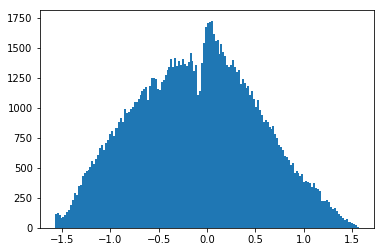

In [106]:
plt.hist(exp_off_dict["IC86_2011"]["dec"], bins=_b)
plt.show()

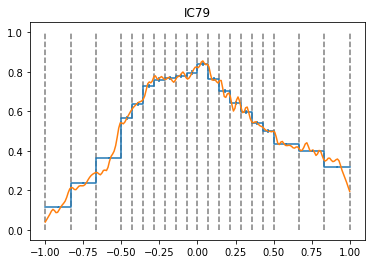

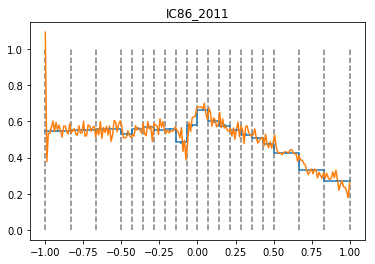

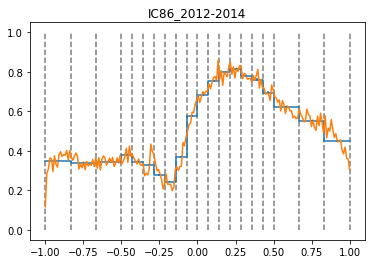

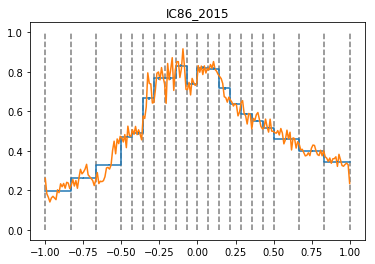

In [95]:
# Compare hist to allsky model
x = np.linspace(-1, 1, 200)
for key, bg_inj in sorted(multi_bg_inj._injs.items())[:]:
    bins = bg_inj_opts[key]["sindec_bins"]
    plt.vlines(bins, 0, 1, linestyles="--",
               colors="C7", zorder=-1)
    h, b = np.histogram(np.sin(exp_off_dict[key]["dec"]),
                        bins=bins, density=False)
    m = 0.5 * (b[:-1] + b[1:])
    norm = np.diff(b) * np.sum(h)
    err = np.sqrt(h)
    h_n = h / norm
    err_n = err / norm
    
    plt.plot(b, np.r_[h_n[0], h_n], drawstyle="steps-pre", c="C0")
    plt.errorbar(m, h_n, yerr=err_n, fmt=",", color="C0")
    
    plt.plot(x, bg_inj._spl_info["data_sin_dec_pdf_spline"](x), c="C1")
    plt.title(key)
#     save_plot(os.path.join("bg_injector", "allsky_model"),
#               key + ".png", dpi=200)
    plt.show()

Show that sampled distribtuion follows PDFs

Sample  IC79
[3.1978479088918084, 3.3203782740624868, 3.3125563062804995]
[3.19784891 3.32037941 3.31255743]


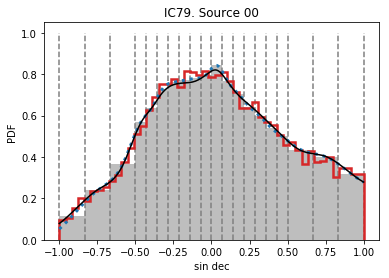

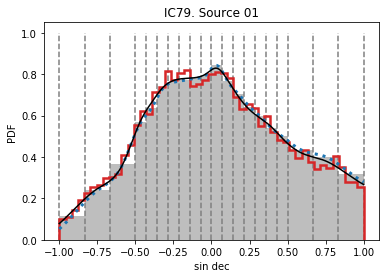

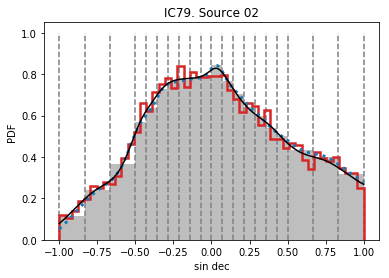

Sample  IC86_2012-2014
[3.487375866480206, 3.426727809637244, 3.581085620634365, 3.580741348742319, 3.576437129865971, 3.553505578600398, 3.472028299529434, 3.4353486417299304, 3.563922929045922, 3.577860486319701, 3.583844180165239, 3.4619987642205605]
[3.48737641 3.4267284  3.58108609 3.58074182 3.5764376  3.55350607
 3.47202885 3.43534922 3.56392341 3.57786096 3.58384464 3.46199933]


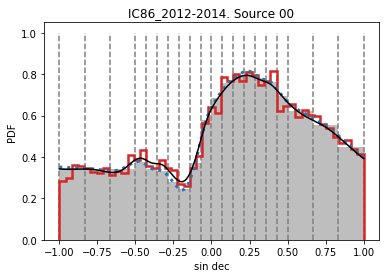

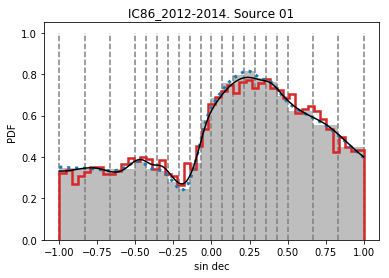

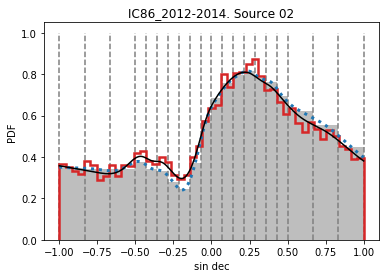

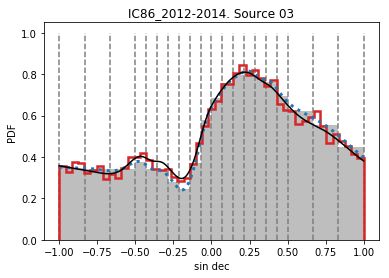

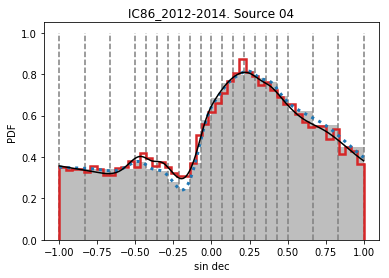

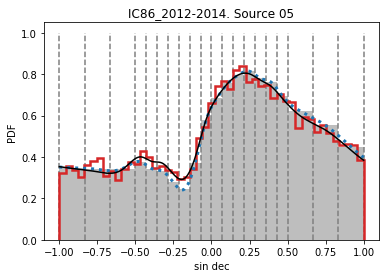

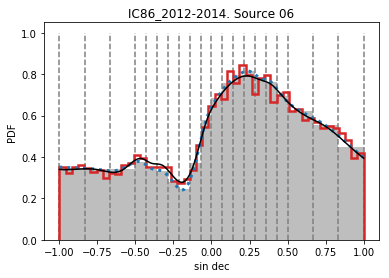

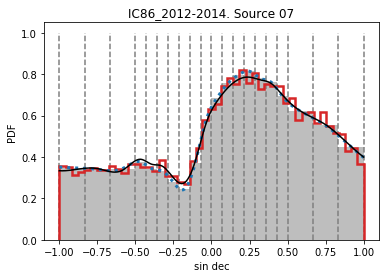

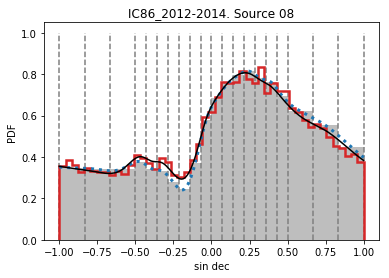

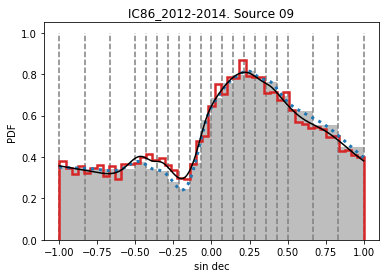

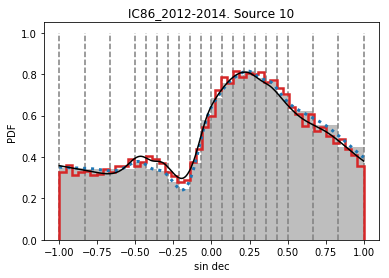

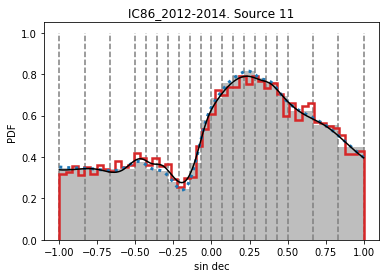

Sample  IC86_2011
[4.300634343678241, 4.6196902262673305, 4.622250971313145, 4.411532732778767]
[4.30063493 4.61969054 4.62225128 4.41153322]


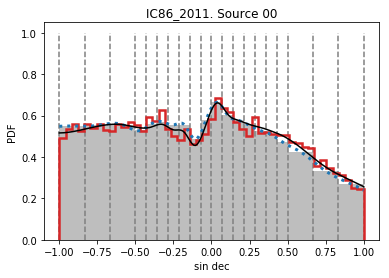

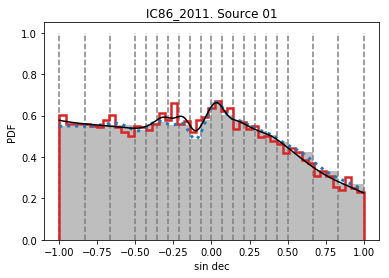

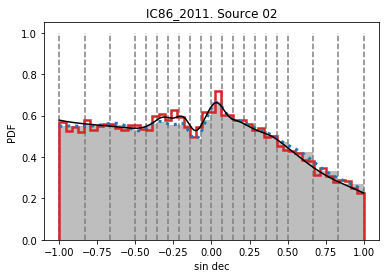

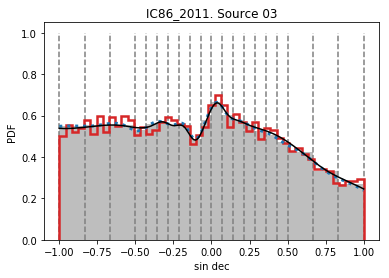

Sample  IC86_2015
[6.202974198441108, 6.440165041428653, 6.231215671552185]
[6.20297499 6.44016597 6.23121648]


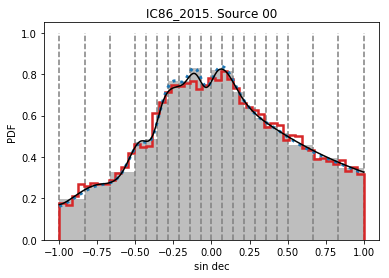

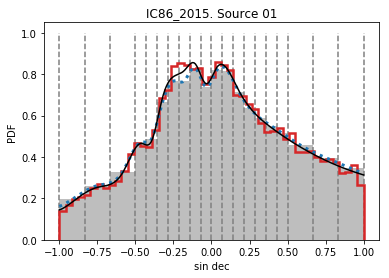

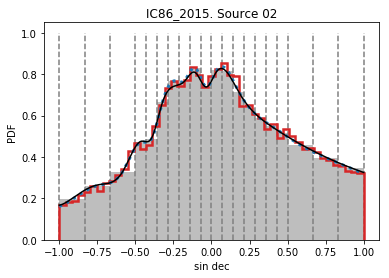

In [91]:
for key, bg_inj in multi_bg_inj.injs.items():
    print("Sample ", key)
    nsrcs = len(bg_inj.srcs)
    sam = [list() for _ in range(nsrcs)]
    # Sample a few times to have better stats for smaller timw windows
    nsamples = 5000
    for _ in range(nsamples):
        sami = bg_inj.sample(debug=True)
        src_idx = bg_inj._sample_idx["src_idx"]
        for j in range(nsrcs):
            sam[j].append(sami[src_idx == j])

    sam = [np.concatenate(sami) for sami in sam]
    # These should match closely
    print(map(lambda spl: spl.integral(-1, 1),
              bg_inj._spl_info["sin_dec_splines"]))
    print(bg_inj._nb)
    
    # Plot average all data distribution and the spline for each source
    x = np.linspace(-1, 1, 200)
    sindec_bins = bg_inj.inj_opts["sindec_bins"]
    _bins = np.linspace(-1, 1, 50)

    for j, sami in enumerate(sam):
        plt.vlines(sindec_bins, 0, 1, linestyles="--", colors="C7", zorder=-1)
        # Plot allyear sample for comparison
        h, b, _ = plt.hist(np.sin(exp_off_dict[key]["dec"]), bins=sindec_bins,
                           density=True, color="C7", alpha=0.5)
        _spl = fit_spl_to_hist(h=h, bins=b)[0]
        plt.plot(x, _spl(x), color="C0", ls=":", lw=3)
        # Drawn sample per source. Red hist should approx. follow black spline
        # It doesnt here because we need to make the allsky bg spline follow the
        # data as close as possbile, but we chose sindec spliens so that didn't work
        plt.hist(np.sin(sami["dec"]), bins=_bins, density=True,
                 histtype="step", lw=2.5, color="C3")
        plt.plot(x, bg_inj._spl_info["sin_dec_pdf_splines"][j](x), color="k")
        plt.xlabel("sin dec")
        plt.ylabel("PDF")
        plt.title("{}. Source {:02d}".format(key, j))

#         save_plot(os.path.join("bg_injector", "sindec_splines"),
#                   "{}_src_{:02d}.png".format(key, j))
        plt.show()

Show sampling weights

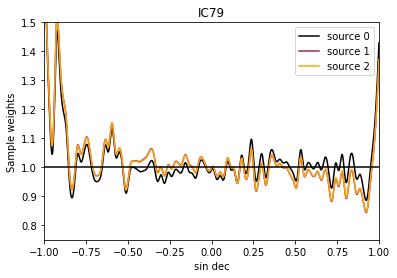

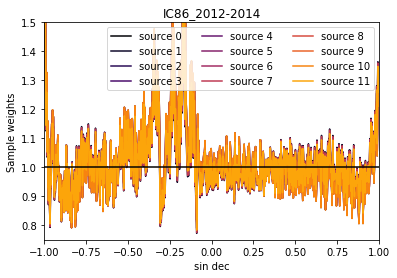

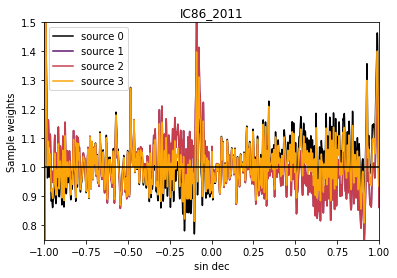

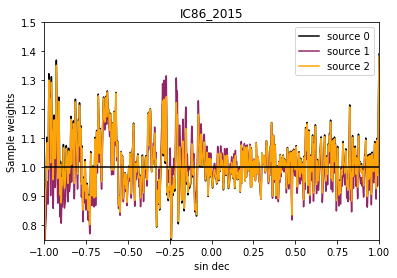

In [92]:
for key, bg_inj in multi_bg_inj.injs.items():
    pts = np.sin(exp_off_dict[key]["dec"])
    idx = np.argsort(pts)
    pts = pts[idx]

    nsrcs = len(bg_inj.srcs)
    c = plt.cm.inferno(np.linspace(0, 0.8, nsrcs))
    for j, w in enumerate(bg_inj._spl_info["sample_weights"]):
        plt.plot(pts, w[idx], label="source {}".format(j), color=c[j])

    plt.axhline(1, 0, 1, c="k")
    plt.xlabel("sin dec")
    plt.ylabel("Sample weights")
    plt.title("{}".format(key))
    plt.xlim(-1, 1)
    plt.ylim(0.75, 1.5)   
    plt.legend(ncol=nsrcs // 5 + 1, loc="best")

#     save_plot(os.path.join("bg_injector", "sample_weights"),
#               "{}_sample_weights.png".format(key))
    plt.show()

Build the allsky histogram with much more bins and just fit the spline with the poisson errors, which should catch all the non-statistics details correctly.

For the used allsky model: Used the same binning as for the parameter splines.
It should be better to use the finest binning possible, because the spline is only used for the weighted injection per source.
The finer we describe the details in data the more accurate the sampling.

In [ ]:
# Compare hist to allsky model
x = np.linspace(-1, 1, 200)
bins = np.linspace(x[0], x[-1], 100)
for key, bg_inj in sorted(multi_bg_inj._injs.items())[:]:
    plt.vlines(bg_inj_opts[key]["sindec_bins"], 0, 1, linestyles="--",
               colors="C7", zorder=-1)
    h, b = np.histogram(np.sin(exp_off_dict[key]["dec"]),
                        bins=bins, density=False)
    m = 0.5 * (b[:-1] + b[1:])
    norm = np.diff(b) * np.sum(h)
    err = np.sqrt(h)
    h_n = h / norm
    err_n = err / norm
    _spl = fit_spl_to_hist(h_n, b, w=1. / err_n, s=len(h), k=3, ext=0)[0]
    
    plt.plot(b, np.r_[h_n[0], h_n], drawstyle="steps-pre", c="C0")
    plt.errorbar(m, h_n, yerr=err_n, fmt=",", color="C0")   
    plt.plot(x, bg_inj._spl_info["data_sin_dec_pdf_spline"](x), c="k", ls="--")
    plt.plot(x, _spl(x), c="C1")
    
    save_plot(os.path.join("bg_injector", "allsky_model_fine_bins"),
          key + ".png", dpi=200)
    plt.show()

#### MC injector

Test splitting of signal samples

In [ ]:
nsamples = 10000
multi_sig_sam = multi_sig_inj.sample(n_samples=nsamples)
# Total sample weight should be normed to 1
print(sum(map(len, (multi_sig_sam.values()))))
print(nsamples * sum(multi_sig_inj._distribute_weights.values()))
# Show sampled events from each injector and split weights normed to tot samples
print(dict_map(lambda key, sam: len(sam), multi_sig_sam))
print(dict_map(lambda key, wts: "{:.1f}".format(wts * nsamples),
               multi_sig_inj._distribute_weights))

Show sample distributions

In [ ]:
for key, sami in multi_sig_sam.items():
    # Sampled MC hist
    _inj = multi_sig_inj.injs[key]
    _idx = multi_sig_inj.injs[key]._sample_idx
    for name in ["ra", "dec", "logE", "time", "sigma"]:
        # Show sampled data-like attributes
        if name != "time":
            # Compare to full MC pool distribution
            w = _inj._MC["ow"] * _inj.flux_model(_inj._MC["trueE"])
            if name == "sigma" and key == "IC86_2015":
                bins = np.linspace(0, np.amax(sami[name]), 100)
            else:
                bins = 100

            _ = plt.hist(_inj._MC[name], weights=w, density=True, bins=bins,
                         alpha=.5)
            _ = plt.hist(sami[name], density=True, bins=bins,
                         histtype="step", lw=3)
        if name in ["ra", "dec"]:
            plt.vlines(_inj.srcs[name], 0, 1)
            plt.yscale("log", nonposy="clip")
        if name == "time":
            ts = _inj.srcs["time"]
            dt0s, dt1s = _inj.srcs["dt0"], _inj.srcs["dt1"]
            for j in range(len(ts)):
                plt.title("{}. {:.2f}, {:.2f}, {:.2f}".format(
                    name, ts[j], dt0s[j], dt1s[j]))
                mask = (_idx["src_idx"] == j)
                trel = (ts[j] - sami[name][mask]) * SECINDAY
                _ = plt.hist(trel, density=False, bins=bins,
                             histtype="step", lw=3)
                plt.axvline(0, 0, 1)
                plt.axvline(dt0s[j], 0, 1, ls="--")
                plt.axvline(dt1s[j], 0, 1, ls="--")
                save_plot(os.path.join("sig_inj", "sample"),
                          "{}_time_src_{}.png".format(key, j), dpi=150)
                plt.show()
        else:
            plt.title("{}: {}".format(key, name))
            save_plot(os.path.join("sig_inj", "sample"),
                      "{}_{}.png".format(key, name), dpi=150)
            plt.show()

Sample from each injector on its own and show that the expected number of events match.

In [ ]:
nsamples = 10000

# Plot for each sample
for key in sorted(multi_sig_inj.injs.keys()):
    _inj = multi_sig_inj.injs[key]
    _grb_mod = multi_llh.model[key]
    _Xsig = _inj.sample(n_samples=nsamples)
    _src_idx = _inj._sample_idx["src_idx"]

    bins = _grb_mod._spatial_opts["sindec_bins"]
    mids = 0.5 * (bins[:-1] + bins[1:])
    lo, hi = bins[0], bins[-1]

    # Make signal distribution from which is sampled
    w_sig = mc_dict[key]["ow"] * _inj._flux_model(mc_dict[key]["trueE"])
    sindec = np.sin(mc_dict[key]["trueDec"])
    hist, _ = np.histogram(sindec, bins=bins, weights=w_sig)
    var, _ = np.histogram(sindec, bins=bins, weights=w_sig**2)
    dA = np.diff(bins)
    hist = hist / dA
    stddev = np.sqrt(var) / dA

    # Normalize hist as injection weights: sum w = 1. Weights from src weights
    src_w = _grb_mod.get_args()["src_w_dec"]
    norm = np.sum(src_w)
    hist = hist / norm
    stddev = stddev / norm
    spl = _grb_mod._spl_info["mc_sin_dec_pdf_spline"]

    # Plot the spline and the histogram
    x = np.linspace(lo, hi, 250)
    plt.plot(bins, np.r_[hist[0], hist], drawstyle="steps-pre", color="C7")
    plt.errorbar(mids, hist, yerr=stddev, fmt=",", color="C7")
    plt.plot(x, spl(x) / norm)

    for j, srci in enumerate(_inj.srcs):
        # Plot source positions in dec
        plt.axvline(np.sin(srci["dec"]), 0, 1, ls="--", c="C7")
        # Plot relativ number of sampled events per src
        m = (_src_idx == j)
        nsam = np.sum(m) / len(m)
        nsam_err = np.sqrt(np.sum(m)) / len(m)
        plt.errorbar(np.sin(srci["dec"]), nsam, yerr=nsam_err,
                     fmt="o", c="C{}".format(j % 9), zorder=5, alpha=1.)
        # Plot 1D scatter of sampled events per source
        plt.vlines(np.sin(_Xsig[m]["dec"]), -0.15 * np.amax(hist), 0.,
                   linestyles="-", colors="C{}".format(j % 9), alpha=0.1)
        # Plot expected relativ event numbers (spline values)
        plt.plot(np.sin(srci["dec"]), src_w[j] / norm, c="C{}".format(j % 9),
                 marker="d", ls="", mec="k", zorder=6)

        plt.axhline(0, 0, 1, c="k", ls="-")

    plt.ylim(-0.15 * np.amax(hist), None)
    plt.title(key)

    # plt.savefig("/Users/tmenne/Downloads/mc_inject_expect_" +
    #             "{}_nsam={}.png".format(sample_name, nsamples), dpi=200)
    plt.show()

Now sample the multiinjector and get the events per injector and per source to see that the expectation still matches

In [ ]:
# Sample with the multi injector and entangle to check single sample plots
nsamples = 10000
sam = multi_sig_inj.sample(nsamples)
# Get samples event and source indices
sig_idx = dict_map(lambda k, inj: inj._sample_idx, multi_sig_inj.injs)

# Print stats
print("Total samples: ", sum([len(sami) for sami in sam.values()]))
for key, sami in sam.items():
    _dw = multi_sig_inj._distribute_weights[key]
    _space = int(np.ceil(np.log10(nsamples)))
    print("  - {0:15s}: {1:{3:}d} (Expected: {2:{4:}.1f})".format(
        key, len(sami), nsamples * _dw, _space, _space + 2))

In [ ]:
# Plot for each sample
for key in sorted(multi_sig_inj.injs.keys()):
    _inj = multi_sig_inj.injs[key]
    _grb_mod = multi_llh.model[key]
    _Xsig = sam[key]
    _src_idx = sig_idx[key]["src_idx"]

    bins = _grb_mod._spatial_opts["sindec_bins"]
    lo, hi = bins[0], bins[-1]
    bins = np.linspace(lo, hi, 100)  # Overwrite for finer binning
    mids = 0.5 * (bins[:-1] + bins[1:])

    # Make signal distribution from which is sampled
    w_sig = mc_dict[key]["ow"] * _inj._flux_model(mc_dict[key]["trueE"])
    sindec = np.sin(mc_dict[key]["trueDec"])
    hist, _ = np.histogram(sindec, bins=bins, weights=w_sig)
    var, _ = np.histogram(sindec, bins=bins, weights=w_sig**2)
    dA = np.diff(bins)
    hist = hist / dA
    stddev = np.sqrt(var) / dA

    # Normalize hist as injection weights: sum w = 1. Weights from src weights
    src_w = _grb_mod.get_args()["src_w_dec"]
    norm = np.sum(src_w)
    hist = hist / norm
    stddev = stddev / norm
    spl = _grb_mod._spl_info["mc_sin_dec_pdf_spline"]

    # Plot the spline and the histogram
    x = np.linspace(lo, hi, 250)
    plt.plot(bins, np.r_[hist[0], hist], drawstyle="steps-pre", color="C7")
    plt.errorbar(mids, hist, yerr=stddev, fmt=",", color="C7")
    plt.plot(x, spl(x) / norm)

    for j, srci in enumerate(_inj.srcs):
        # Plot source positions in dec
        plt.axvline(np.sin(srci["dec"]), 0, 1, ls="--", c="C7")
        # Plot relativ number of sampled events per src
        m = (_src_idx == j)
        nsam = np.sum(m) / len(m)
        nsam_err = np.sqrt(np.sum(m)) / len(m)
        plt.errorbar(np.sin(srci["dec"]), nsam, yerr=nsam_err,
                     fmt="o", c="C{}".format(j % 9), zorder=5, alpha=1.)
        # Plot 1D scatter of sampled events per source
        plt.vlines(np.sin(_Xsig[m]["dec"]), -0.15 * np.amax(hist), 0.,
                   linestyles="-", colors="C{}".format(j % 9), alpha=0.1)
        # Plot expected relativ event numbers (spline values)
        plt.plot(np.sin(srci["dec"]), src_w[j] / norm, c="C{}".format(j % 9),
                 marker="d", ls="", mec="k", zorder=6)

        plt.axhline(0, 0, 1, c="k", ls="-")

    plt.ylim(-0.15 * np.amax(hist), None)
    plt.title(key)

    save_plot(os.path.join("sig_inj", "mc_inject_expect"),
              "{}_nsam={}.png".format(key, len(_src_idx)), dpi=250)
    plt.show()

#### LLH Model

Energy PDF ratios

In [ ]:
for key, grb_mod_i in multi_llh.model.items():
    xbins = grb_mod_i.energy_opts["bins"][0]
    ybins = grb_mod_i.energy_opts["bins"][1]

    xlo, xhi = np.amin(xbins), np.amax(xbins)
    ylo, yhi = np.amin(ybins), np.amax(ybins)

    x = np.linspace(xlo, xhi, 250)
    y = np.linspace(ylo, yhi, 250)
    xx, yy = np.meshgrid(x, y)

    xmids, ymids = map(lambda b: 0.5 * (b[:-1] + b[1:]), [x, y])
    XX, YY = map(np.ravel, np.meshgrid(xmids, ymids))
    pts = np.vstack((XX, YY)).T

    # zz = grb_mod_i._energy_interpol(pts)
    zz = grb_mod_i._soverb_energy(XX, YY)
    zz = zz.reshape(len(xmids), len(ymids))

    plt.pcolormesh(xx, yy, np.log10(zz), cmap="coolwarm", vmin=-3, vmax=3)
    cbar = plt.colorbar()

    cbar.set_label("log10(S/B)")
    plt.xlabel("sin(dec)")
    plt.ylabel("log10(E proxy / GeV)")
    plt.title(key)

    save_plot(os.path.join("llh_model", "energy_pdfs"), key, dpi=300)
    plt.show()

Expected signal stacking weights

In [ ]:
# Plot for each sample
for key in sorted(multi_sig_inj.injs.keys()):
    _inj = multi_sig_inj.injs[key]
    _grb_mod = multi_llh.model[key]

    bins = np.linspace(-1, 1, 100)
    mids = 0.5 * (bins[:-1] + bins[1:])
    lo, hi = bins[0], bins[-1]

    # Make signal distribution from which is sampled
    w_sig = mc_dict[key]["ow"] * _inj._flux_model(mc_dict[key]["trueE"])
    sindec = np.sin(mc_dict[key]["trueDec"])
    hist, _ = np.histogram(sindec, bins=bins, weights=w_sig)
    var, _ = np.histogram(sindec, bins=bins, weights=w_sig**2)
    dA = np.diff(bins)
    hist = hist / dA
    stddev = np.sqrt(var) / dA

    # Normalize hist as injection weights: sum w = 1. Weights from src weights
    src_w = _grb_mod.get_args()["src_w_dec"]
    norm = np.sum(src_w)
    hist = hist / norm
    stddev = stddev / norm
    spl = _grb_mod._spl_info["mc_sin_dec_pdf_spline"]

    # Plot the spline and the histogram
    x = np.linspace(lo, hi, 250)
    plt.plot(bins, np.r_[hist[0], hist], drawstyle="steps-pre", color="C7")
    plt.errorbar(mids, hist, yerr=stddev, fmt=",", color="C7")
    plt.plot(x, spl(x) / norm)

    c = plt.cm.inferno(np.linspace(0., 0.8, len(_inj.srcs)))
    for j, srci in enumerate(_inj.srcs):
        # Plot source positions in dec
        plt.axvline(np.sin(srci["dec"]), 0, 1, ls="--", c="C7")
        # Plot expected relativ event numbers (spline values)
        plt.plot(np.sin(srci["dec"]), src_w[j] / norm, c=c[j], marker="d",
                 ls="", mec="k", zorder=6, label="src {}".format(j))
        plt.axhline(0, 0, 1, c="k", ls="-")

    plt.ylim(-0.15 * np.amax(hist), None)
    plt.xlabel("sin(dec)")
    plt.title(key)
    plt.legend(ncol=len(_inj.srcs) // 5 + 1)

    save_plot(os.path.join("llh_model", "stacking_src_weights"), key, dpi=100)
    plt.show()

#### Analysis

##### BG trials

Timing tests: For 6 year pass2 HESE, 5 years PS tracks data, 1 year GFU

- tw00: 1e8 trials in 11h 19min 6s -> ~2455 trials / sec
- tw10: 1e5 trials in ~193s -> ~ 518 trials / sec
- tw20: 1e4 trials in ~430s -> ~  23 trials / sec

In [ ]:
%%time
print("Time window ID is: {}".format(tw_id))
n_trials = int(1e8)
n_signal = 0
trials, nzeros, nsig = ana.do_trials(n_trials=n_trials, ns0=0.1, full_out=False)

ns, ts = trials["ns"], trials["ts"]

In [ ]:
out = {
    "ns": trials["ns"].tolist(),
    "ts": trials["ts"].tolist(),
    "time_window": [dt0, dt1],
    "time_window_id": tw_id,
    "nzeros": nzeros,
    "rnd_seed": [42439462],
    "ntrials": n_trials,
    "ntrials_per_batch": [n_trials],
    }
outpath = "/Users/tmenne/Downloads/"
fpath = os.path.join(outpath, "tw_{:02d}.json.gz".format(tw_id))
with gzip.open(fpath, "w") as outf:
    json.dump(out, fp=outf, indent=2)
    print("- Saved to:\n    {}".format(fpath))

Try stuff

##### Create empirical PDFs

In [ ]:
%%time
_tw = 20
fpath = os.path.join(PATHS.data, "bg_trials_combined",
                     "tw_{:02d}.json.gz".format(_tw))
with gzip.open(fpath) as inf:
    trials = json.load(inf)
    print("- Loaded:\n    {}".format(fpath))
    
nzeros = trials["nzeros"]
ntrials = trials["ntrials"]
trials["ts"] = np.array(trials["ts"])
trials["ns"] = np.array(trials["ns"])

Scan thresholds to select a good one.

In [ ]:
%%time
# Scan it
emp_dist = stats.emp_with_exp_tail_dist(trials["ts"], trials["nzeros"],
                                        thresh=np.amax(trials["ts"]))
pval_thresh = 0.5
lo, hi = emp_dist.ppf(q=100. * stats.sigma2prob([3., 5.5]))
thresh_vals = np.arange(lo, hi, 0.1)
best_thresh, best_idx, pvals, scales = stats.scan_best_thresh(
    emp_dist, thresh_vals, pval_thresh=pval_thresh)

In [ ]:
%%time
# Save it in float16
fname = "/Users/tmenne/Downloads/bg_pdf_tw_{:02d}.json.gz".format(_tw)
with gzip.open(fname, "w") as f:
    emp_dist.to_json(fp=f, dtype=np.float16, indent=1, separators=(",",":"))

Plot ts and ns

In [ ]:
def make_bg_pdf_scan_plots(fname, emp_dist, thresh_vals, pvals, scales,
                           pval_thresh):
    def _plot_sigma_lines(ax, sigmas):
        sigmas = np.sort(sigmas)
        q = 100. * np.atleast_1d(stats.sigma2prob(sigmas))
        _p = stats.percentile_nzeros(emp_dist.data, emp_dist.nzeros,
                                     q=q, sorted=True)
        for i, pi in enumerate(_p):
            ax.axvline(pi, 0, 1, ls="--", c="C7",
                       alpha=sigmas[i] / np.amax(sigmas),
                       label=r"{:.1f}$\sigma$".format(sigmas[i]))

    fig, (axl, axc, axr) = plt.subplots(1, 3, figsize=(17.5, 5))

    # ## Left: Plot the selected combined PDF ##
    # Plot empirical PDF part
    h, b, err, _ = emp_dist.data_hist(dx=.25, density=True, which="emp")
    axl.plot(b, np.r_[h[0], h], drawstyle="steps-pre", color="k")
    mids = 0.5 * (b[:-1] + b[1:])
    axl.errorbar(mids, h, yerr=err, fmt=",", color="k")
    # Plot exponential data part
    h, b, err, _ = emp_dist.data_hist(dx=.25, density=True, which="exp")
    axl.plot(b, np.r_[h[0], h], drawstyle="steps-pre", color="C7")
    mids = 0.5 * (b[:-1] + b[1:])
    axl.errorbar(mids, h, yerr=err, fmt=",", color="C7")
    # Plot the exponetial PDF part
    x = np.linspace(emp_dist.thresh, np.amax(emp_dist.data), 100)
    axl.plot(x, emp_dist.pdf(x), color="C3",
             label=("exp tail\n" +
                    r"$\lambda$={:.2f}".format(1. / emp_dist.scale)))
    axl.axvline(emp_dist.thresh, 0, 1, ls=":", color="C3")
    _plot_sigma_lines(axl, [3., 4., 5., 5.5])
    axl.set_yscale("log", nonposy="clip")
    axl.set_xlabel("ts")
    axl.set_title("Test Statitics")
    axl.legend()

    # ## Center: Plot the selected combined p-values ##
    x = np.linspace(0, np.amax(emp_dist.data), 500)
    cdf_emp = 1. - stats.cdf_nzeros(emp_dist.data, emp_dist.nzeros, vals=x,
                                    sorted=True)
    cdf_dist = emp_dist.sf(x)
    axc.plot(x, cdf_emp, color="k")
    axc.plot(x, cdf_dist, color="C3")
    axc.axvline(emp_dist.thresh, 0, 1, ls=":", color="C3", label="threshold")
    _plot_sigma_lines(axc, [3., 4., 5., 5.5])
    axc.set_yscale("log", nonposy="clip")
    axc.set_xlabel("ts")
    axc.set_title("p-values")
    axc.legend()

    # ## Right: Threshold scan
    _plot_sigma_lines(axr, [3., 4., 5., 5.5])
    axr.axhline(1, 0, 1, ls="--", c="C7")
    axr.axhline(pval_thresh, 0, 1, ls="-", c="C7")      # Rejection line
    axr.axvline(emp_dist.thresh, 0, 1, ls="-", c="k")   # Best thresh
    axr.plot(thresh_vals, pvals, c="C1", label="KS pval")
    axr.plot(thresh_vals, 1. / scales, c="C2", label="lambdas")
    axr.set_xlabel("ts")
    axr.set_title("Best thresh: {:.2f}".format(emp_dist.thresh))
    axr.legend()
    
    for axi in [axl, axc, axr]:
        axi.set_xlim(0, 40)

    fig.tight_layout()
    plt.savefig(fname, dpi=200, bbox_inches="tight")

    plt.show()

In [ ]:
make_bg_pdf_scan_plots("/Users/tmenne/Downloads/tw_{}.png".format(_tw),
                       emp_dist, thresh_vals, pvals, scales, pval_thresh)

In [ ]:
# Plot the ns distribution
ns = trials["ns"]
dx = 0.5
bins = np.arange(0, max(1, np.amax(ns)) + dx, dx)
mids = 0.5 * (bins[:-1] + bins[1:])

h, _ = np.histogram(ns, bins=bins, density=False)
h[0] += trials["nzeros"]
norm = np.diff(bins) * np.sum(h)
err = np.sqrt(h) / norm
h = h / norm

plt.plot(bins, np.r_[h[0], h], drawstyle="steps-pre", color="k")
plt.errorbar(mids, h, yerr=err, fmt=",", color="k")
    
plt.yscale("log", nonposy="clip")
plt.xlabel("ns")
plt.show()

Make some CDF, SF and PPF verification plots

In [ ]:
emp_dist = stats.emp_with_exp_tail_dist(trials["ts"], trials["nzeros"],
                                        thresh=best_thresh)

In [ ]:
x = np.linspace(0, 30, 500)
y = emp_dist.pdf(x, dx=0.25)

h, b, _, _ = emp_dist.data_hist(dx=0.25, density=True, which="exp")
plt.plot(b, np.r_[h[0], h], drawstyle="steps-pre", c="C7", alpha=.75)

plt.plot(x, y, c="k")

plt.yscale("log")
plt.show()

In [ ]:
x = np.linspace(0, 30, 500)
y = emp_dist.cdf(x)
plt.plot(x, y, c="k", label="fitted CDF")

plt.xlabel("test statistic")
plt.ylabel("CDF")
plt.ylim(1. - len(emp_dist.data) / emp_dist.nzeros, 1)
plt.ylim(0.9998, 1)
plt.show()

In [ ]:
x = np.linspace(0, 30, 500)
y = emp_dist.sf(x)
plt.plot(x, y, c="k", label="fitted SF")

y2 = 1. - stats.cdf_nzeros(emp_dist.data, emp_dist.nzeros, vals=x, sorted=True)
plt.plot(x, y2, c="C3", ls="--", label="empiric SF")

plt.xlabel("test statistic")
plt.ylabel("p-value")
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
q = np.linspace(sigma2prob(4), sigma2prob(6), 500)
y = emp_dist.ppf(q * 100.)
plt.plot(q, y, c="k", label="fitted CDF")

plt.xlabel("percentile")
plt.ylabel("PPF")
plt.show()

Integrate PDF and compare in tail

In [ ]:
def exp_pdf_integral(exp_pars, bins):
    loc, scale = exp_pars
    lam = 1. / scale
    lo, hi = np.vstack([bins[:-1], bins[1:]])
    return np.exp(lam * loc) * (np.exp(-lam * lo) - np.exp(-lam * hi))

# Plot data hist
dx = 0.25
h, b, err, exp_norm = emp_dist.data_hist(dx, density=True, which="exp")
plt.plot(bins, np.r_[h_n[0], h_n], drawstyle="steps-pre", color="C7")
mids = 0.5 * (b[:-1] + b[1:])
plt.errorbar(mids, h, yerr=err, fmt=",", color="C7")

# Plot binned exponential tail
pdf_binned = exp_norm * exp_pdf_integral(
    (emp_dist.thresh, emp_dist.scale), b) / np.diff(b)
plt.plot(b, np.r_[pdf_binned[0], pdf_binned],
         drawstyle="steps-pre", color="C3")

plt.xlabel("ts")
plt.xlim(emp_dist.thresh, None)
plt.ylim(10**np.floor(np.log10(np.amin(pdf_binned))),
         10**np.ceil(np.log10(np.amax(pdf_binned))))
plt.yscale("log", nonposy="clip")

plt.show()

##### Compare PDFs to independent trials

We made a second set of independent trials for all time windows.
We can compare the built PDFs with the new trials and see if the model was chosen OK.

In [ ]:
def _load_lido_bg_pdfs(tw_id):
    path = os.path.join(PATHS.local, "bg_pdfs_lido",
                        "bg_pdf_tw_{:02d}.json.gz".format(tw_id))
    with gzip.open(path) as json_file:
        emp_dist = stats.emp_with_exp_tail_dist.from_json(json_file)
        
    return emp_dist

In [ ]:
all_ids = loader.time_window_loader()
pvals = []

dists = []
dists_lido = []

for _tw in all_ids:
    print("Testing tw {}".format(_tw))
    emp_dist = loader.bg_pdf_loader(_tw)[_tw]
    emp_dist_lido = _load_lido_bg_pdfs(_tw)
    
    # Get best fit loc, scale from original trials
    loc, scale = emp_dist.thresh, emp_dist.scale
    # Get the lido trial data for the KS test in that region
    emp_dist_lido.fit_thresh(loc)
    lido_over_thresh_data, _ = emp_dist_lido.get_split_data(emp=False)
    
    pvals.append(scs.kstest(lido_over_thresh_data, "expon",
                            args=(loc, scale)).pvalue)
    dists.append(emp_dist)
    dists_lido.append(emp_dist_lido)

In [ ]:
plt.plot(all_ids, pvals)
plt.yscale("log")
for sigi in sigma2prob([1, 2, 3, 4, 5]):
    plt.axhline(1. - sigi, 0, 1, ls="--", c="C7")
plt.xticks(all_ids[::2])
plt.xlabel("tw ID")
plt.ylabel("p-value")
plt.xlim(all_ids[0], all_ids[-1])
plt.ylim(None, 1)

save_plot(os.path.join("bg_trials", "ks_test_lido_trials"), "pvalues.png")
plt.show()

In [ ]:
for i, ed in enumerate(dists):
    x = np.linspace(0, ed.data.max(), 500)
    y = ed.pdf(x, dx=0.1)
    h, b, err, norm = dists_lido[i].data_hist(dx=0.25, which="exp",
                                              density=True)
    m = 0.5 * (b[:-1] + b[1:])

    plt.plot(b, np.r_[h[0], h], c="C7", drawstyle="steps-pre",
             label="lido trials")
    plt.errorbar(m, h, yerr=err, c="C7", fmt=",")
    plt.plot(x, y, label="orig trial PDF")

    plt.yscale("log")
    plt.title(i)
    plt.legend()
    save_plot(os.path.join("bg_trials", "ks_test_lido_trials", "dist_compare"),
              "tw_{:02d}.png".format(i), dpi=300)
    plt.show()

##### Performance

In [ ]:
%%time
beta = 0.9
ts_val = 0.
ns0 = 1.
mu_sig = np.r_[0.1, 0.5, np.arange(1, 20, 1)]
n_batch_trials = 2500

perf = ana.performance(ts_val=ts_val, beta=beta, mus=mu_sig, ns0=ns0,
                       n_batch_trials=n_batch_trials)

Get n sigma ts values from BG PDF and show performance for these.

In [ ]:
# Change typ 'healpy' | 'ps' and make all plots in cells below
typ = "ps"
sigmas = [1, 2, 3, 4, 5]
betas = [0.9, 0.9, 0.9, 0.9, 0.9]
tw_ids = loader.time_window_loader()

# Store mus per sigma, beta and tw combination
mu_bfs = []
ts_vals = []

for _tw in tw_ids:
    emp_dist = loader.bg_pdf_loader(_tw)[_tw]
    perf = loader.perf_trials_loader(typ=typ, idx=_tw)[_tw]

    ts_vals_tw = emp_dist.ppf(q=100. * sigma2prob(sigmas))
    ts_vals.append(ts_vals_tw)

    x = np.linspace(0, perf["mus"][-1], 100)
    ls = ["-", "-.", "--", ":", ":"][::-1]
    assert len(ls) == len(ts_vals_tw)

    # Plot performances
    mu_bfs.append([])
    for beta in betas:
        plt.axhline(beta, 0, 1, ls=":", color="k")
    for i, ts_vali in enumerate(ts_vals_tw):
        p0 = [1., 1., 1.]
        mu_bf, cdfs, pars = stats.fit_chi2_cdf(ts_val=ts_vali, beta=betas[i],
                                               ts=perf["ts"], mus=perf["mus"],
                                               p0=p0)
        print(pars)
        mu_bfs[-1].append(mu_bf)

        plt.axvline(mu_bf, 0, 1, ls=ls[i], color="k", alpha=.5)
        plt.errorbar(perf["mus"], 1. - cdfs, fmt=".", color="k")
        if ts_vali == 0:
            _label = r"{:.0%} > 0".format(betas[i])
        else:
            _label = r"{:.0%} > {:.0f}$\sigma$".format(betas[i], sigmas[i])
        if ts_vali == 0. and i > 0:
            pass
        else:
            plt.plot(x, scs.chi2.cdf(x, *pars), color="C7", ls=ls[i],
                     label=_label)

    plt.xlim(0, None)
    plt.ylim(0, 1)
    plt.xlabel("Mean injected")
    plt.ylabel("Fraction of TS")
    plt.legend(loc="lower right")
    plt.title("Time window {:02d}".format(_tw))
    plt.tight_layout()
    save_plot(os.path.join("performance", typ, "chi2_fits"),
              "tw_{:02d}.png".format(_tw), dpi=250)
    plt.show()
    
print("Done!")

mu_bfs = np.array(mu_bfs)
ts_vals = np.array(ts_vals)

Plot BG PDF n sigma per time windows overview

In [ ]:
_dt0, _dt1 = loader.time_window_loader("all")
_dt = _dt1 - _dt0

ls = ["-", "--", "-.", ":", "-"][::-1]
alpha = [1, 1, 1, 1, 0.5][::-1]

for i, ts_vals_i in enumerate(ts_vals.T[:5]):
    plt.plot(_dt, ts_vals_i, ls=ls[i], color="#353132",
             alpha=alpha[i], label=r"{}$\sigma$".format(sigmas[i]))
plt.xscale("log")
plt.xlabel("Time window length in seconds")
plt.ylabel("TS value")
plt.legend(ncol=2, framealpha=0)
save_plot("performance", "ts_vals.png", dpi=200)
plt.plot()

Plot performance in n inj and flux per for each trial type

In [ ]:
def plot_perf_vs_dt(mu_bfs, sigmas, betas, ls, alphas, typ, mu2flux=None):
    from scipy.optimize import brentq
    def get_poisson_ul(a, b, k=0, beta=0.9):
        return brentq(lambda mu: scs.poisson.sf(k=k, mu=mu) - beta, a, b)

    _dt0, _dt1 = loader.time_window_loader("all")
    _dt = _dt1 - _dt0

    try:
        poisson_k0_90ul = mu2flux(get_poisson_ul(2, 3, k=0, beta=0.9))
    except:
        poisson_k0_90ul = get_poisson_ul(2, 3, k=0, beta=0.9)
    plt.axhline(poisson_k0_90ul, 0, 1, ls=":", alpha=1, color="C7",
                label="Poisson zero BG 90% UL")

    for i, mu_bfs_i in enumerate(mu_bfs.T):
        if mu2flux is None:
            vals = mu_bfs_i
            ylabel = "Mean injected no. of events"
            info = "ninj"
        else:
            vals = mu2flux(mu_bfs_i)
            ylabel = (r"Mean injected flux " +
                      r"$\left(\frac{E}{\mathrm{GeV}}\right)^2\phi$ " +
                      r"in GeV$^{-1}$ cm$^{-2}$")
            info = "flux"
        plt.plot(_dt, vals, ls=ls[i], alpha=alphas[i], color="#353132",
                 label=r"{:.0%} > {:.0f}$\sigma$".format(betas[i], sigmas[i]))
    plt.xscale("log")
    plt.xlabel("Time window length in seconds")
    plt.ylabel(ylabel)
    plt.legend(framealpha=0)
    plt.xlim(_dt[0], _dt[-1])
    plt.ylim(0, None)
    plt.title(r"Performance for $E^{-2}$ signal flux")
    save_plot(os.path.join("performance", typ),
              "perf_{}.png".format(info), dpi=200)
    plt.plot()

In [ ]:
ls = ["-", "--", "-.", ":", "-"][::-1]
alphas = [1, 1, 1, 1, 0.5][::-1]
plot_perf_vs_dt(mu_bfs, sigmas, betas, ls, alphas, typ=typ, mu2flux=None)

In [ ]:
def make_mu2flux(typ="ps"):
    """
    Make mu2flux method from saved mu2fux(1) from healpy or ps injector.
    """
    if typ == "ps":
        fname = os.path.join("/Users", "tmenne", "Downloads",
                             "hese_transient_stacking_data", "mu2flux_ps.json")
    elif typ == "healpy":
        fname = os.path.join("/Users", "tmenne", "Downloads",
                             "hese_transient_stacking_data",
                             "mu2flux_healpy.json")
    else:
        raise ValueError("`typ` can be 'ps' or 'healpy'.")
    with open(fname) as f:
        mu2fluxinfo = json.load(f)

    def mu2flux(mu):
        return mu * mu2fluxinfo["all"]

    return mu2flux

In [ ]:
ls = ["-", "--", "-.", ":", "-"][::-1]
alphas = [1, 1, 1, 1, 0.5][::-1]
plot_perf_vs_dt(mu_bfs, sigmas, betas, ls, alphas, typ=typ,
                mu2flux=make_mu2flux(typ))